# Lending Club Case Study

## Initial Setup

#### Imports

In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Markdown, display
import geopandas as gpd
from pylab import *


env_vars = %env
DATA_PATH = env_vars.get('aiml_data')


#### Utilities

In [244]:
def md(string):
    """
    Prints the string argument with markdown effect

            Parameters:
                    string (str): A string to be printed

            Returns:
                    None
    """
    display(Markdown(string))

In [245]:
def md_vc(series:pd.Series):
    """
    Prints the formatted value_counts() output of the series.

            Parameters:
                    series (pd.Series): A series to be formatted and printed

            Returns:
                    None
    """
    vc = series.value_counts()
    tabl = f'| {vc.index.name} | {vc.name} |'
    tabl += f'\n| :- | --- |'
    for i in range(0, len(vc.array)):
        tabl += f'\n| {vc.index.to_list()[i]} | {vc.array[i]} |'
    md(tabl)

In [246]:
def remove_individual_columns(df:pd.DataFrame):
    cols_to_keep = list()
    cols_to_drop = ['id','member_id','mths_since_last_delinq','mths_since_last_record',
                    'next_pymnt_d','collections_12_mths_ex_med','total_rec_late_fee',
                    'acc_now_delinq','chargeoff_within_12_mths','delinq_amnt',
                    'tax_liens', 'tot_hi_cred_lim', 'initial_list_status',
                    'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 
                    'url', 'policy_code', 'application_type', 'last_pymnt_d', 'last_credit_pull_d',
                   'funded_amnt_inv', 'out_prncp_inv', 'total_pymnt_inv']
    print('shape before cleaning: ', df.shape)
    return df.drop(cols_to_drop, axis='columns').copy()

In [247]:
def rename_columns(to_rename: pd.DataFrame):
    to_rename = to_rename.rename(columns={
        'loan_amnt': 'Loan_Amount', 
        'funded_amnt': 'Funded_Amount', 
        'term': 'Term',
        'int_rate':'Interest_Rate',
        'installment': 'Installment', 
        'grade': 'Grade', 
        'sub_grade': 'Sub_Grade', 
        'emp_title': 'Job_Title', 
        'emp_length': 'Employment_Length',
        'home_ownership': 'Home_Ownership', 
        'annual_inc': 'Annual_Income', 
        'verification_status': 'Verification_Status', 
        'issue_d': 'Loan_Issued_Date',
        'loan_status': 'Loan_Status', 
        'pymnt_plan': 'Payment_Plan', 
        'desc': 'Desc', 
        'purpose':'Purpose', 
        'title': 'Title', 
        'zip_code': 'Addr_Zip',
        'addr_state': 'Addr_State', 
        'dti': 'Debt_to_Income_Ratio', 
        'delinq_2yrs': 'Delinq_2yrs', 
        'inq_last_6mths': 'Inquiries_Last_6mths', 
        'open_acc': 'Open_Credit_Lines', 
        'pub_rec': 'Pub_Record_Derogatory', 
        'revol_bal': 'Revolving_Balance', 
        'revol_util': 'Revolving_Line_Util',
        'total_acc': 'Total_Credit_Line', 
        'out_prncp': 'Outstanding_Principle',
        'total_pymnt': 'Total_Payment', 
        'total_rec_prncp': 'Total_Received_Principle', 
        'total_rec_int': 'Total_Recived_Interest',
        'recoveries': 'Recoveries', 
        'collection_recovery_fee': 'Collection_Recovery_Fee', 
        'last_pymnt_amnt': 'Last_Payment_Amount',
        'pub_rec_bankruptcies': 'Pub_Record_Bankruptcies'}
    )
    return to_rename

In [248]:
def make_bins (*, df:pd.DataFrame, column, trailer=''):
    """
    Makes bins and labels them as 'Lowest','Low','Medium','High','Highest'
    :param df: Data frame to work on
    :param column: Column label of interest
    :param trailer: str value to trail the bin labels
    :return: list of bin ranges and the bins.
    """
    vals = []
    bins = ['Lowest ','Low ','Medium ','High ','Highest ']
    bins = ['(' +
            str(round(np.nanpercentile(df[column], p * 20),2)) +
            trailer + ' - ' +
            str(round(np.nanpercentile(df[column], (p+1) * 20),2)) +
            trailer + ')'
            for p in range(5)]
    print(bins)
    return vals, pd.qcut(df[column], q=5, labels=bins)

In [249]:
def drop_reasons(df:pd.DataFrame, cols: list):
    for col in cols:
        print(col, df[col].value_counts())
    # # Reasons to drop fields
    # df['collections_12_mths_ex_med'].unique()
    # print("total_rec_late_fee: Non-zero count: ", len(df[df['total_rec_late_fee'] != 0]))
    # print("acc_now_delinq: Non-zero count: ", len(df[df['acc_now_delinq'] != 0]))
    # print("chargeoff_within_12_mths: Non-zero count: ", len(df[df['chargeoff_within_12_mths'] != 0]))
    # print("delinq_amnt: Non-zero count: ", len(df[df['delinq_amnt'] == 0]))
    # print("pub_rec_bankruptcies: Non-zero count: ", len(df[df['pub_rec_bankruptcies'] != 0]))
    # print("tax_liens: Non-zero count: ", len(df[df['tax_liens'] == 0]))
    # print("application_type: Non-zero count: ", len(df['application_type'].unique()))

In [250]:
def plot_defaulter_ratio(df: pd.DataFrame, col: str, orient: str = 'h'):
    """
    Plots a bar-plot with percent Loan_Status:'Charged Off' against the column 'col'. Helpful in bivariate analysis.
    :param df: A dataframe to fetch the data from
    :param col: A column in the dataframe
    :param orient: "v" | "h" | "x" | "y" - orientation of the plot
    :return : matplotlib Axes
                    Returns the Axes object with the plot drawn onto it.   
    """
    pcnt_dict = dict()
    for x in df[col].unique():
        t1 = df.loc[(df[col] == x) & (df.Loan_Status == 'Fully Paid')].Loan_Status.count()
        t2 = df.loc[(df[col] == x) & (df.Loan_Status == 'Charged Off')].Loan_Status.count()
        t3 = df.loc[(df[col] == x) & (df.Loan_Status == 'Current')].Loan_Status.count()
        r = round(t2 / (t1 + t3 + t2) * 100, 2)
        pcnt_dict[x] = r
    ax = sns.barplot(pcnt_dict, orient=orient, order=df[col].values)
    plt.title('% of Defaulters vs ' + col)
    plt.show()
    return ax

In [251]:
def subplot_box(dataframes: list, col: str, labels: list, title: str, xlabel: str, ylabel: str, threshold:float=1):
    """
    Plots the subplot for the given list of data frames and columns (categorical).
    :param dataframes: a list/series of Dataframe to work on
    :param col: column in the dataframes
    :param labels: labels of the columns in the exact order
    :param title: title for the plot
    :param xlabel: xlabel for the plot
    :param ylabel: ylabel for the plot
    :param threshold: a number that is good enough to ignore the outliers if that is the intention or nothing
                    to have it outlier friendly
    :return: matplotlib Axes
                    Returns the Axes object with the plot drawn onto it.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    serieses = list()
    for dataframe in dataframes:
        q = dataframe[col].quantile(0.9)
        theshold = q
        # print("q 0.9:", q)
        # print(threshold, "------", q)
        dataframe = dataframe[dataframe[col] <= dataframe[col].quantile(threshold)]
        serieses.append(dataframe[col])
    bp_dict = ax.boxplot(serieses, labels=labels)

    for line in bp_dict['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1]  # top of median line
        # overlay median value
        text(x, y, '%.1f' % y,
             horizontalalignment='right')  # draw above, centered

    for line in bp_dict['boxes']:
        x, y = line.get_xydata()[0]  # bottom of left line
        text(x, y, '%.1f' % y,
             horizontalalignment='right',  # centered
             verticalalignment='top')  # below
        x, y = line.get_xydata()[3]  # bottom of right line
        text(x, y, '%.1f' % y,
             horizontalalignment='right',  # centered
             verticalalignment='top')  # below

    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    return ax

In [252]:
def box_plot(df: pd.DataFrame, col: str, yticklabels: list, xlabel: str = None, threshold: float = 0):
    """
    Plots a box-plot with markings for the quartiles.
    :param df: Dataframe to fetch data from
    :param col: column name
    :param yticklabels: y-ticks
    :param xlabel: x-label
    :param threshold: a number that is good enough to ignore the outliers if that is the intention or nothing
                    to have it outlier friendly
    :return: matplotlib Axes
                    Returns the Axes object with the plot drawn onto it.
    """
    if xlabel == None:
        xlabel = col
    _df = pd.DataFrame
    if threshold == 0:
        _df = df
    else:
        _df = df[df[col] <= threshold]
    fig = plt.figure(1, figsize=(15, 6))
    ax = fig.add_subplot(111)

    ax.boxplot(_df[col], vert=False, manage_ticks=True)
    ax.set_xlabel(xlabel)
    # ax.set_yticks([1])
    ax.set_yticklabels(yticklabels)

    quantiles = np.quantile(_df[col], np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
    ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
              color='b', ls=':', lw=0.5, zorder=0)
    ax.set_ylim(0.5, 1.5)
    ax.set_xticks(quantiles)
    plt.show()
    # return ax

***

## Data Preparation

### Load Data

In [253]:
loan = pd.read_csv(DATA_PATH + '/loan.csv', low_memory=False)

### Understanding the Data

In [254]:
loan.shape

(39717, 111)

There are 31,717 records across 111 columns.

In [255]:
loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)

In [256]:
loan.isna().sum()/loan.shape[0]

id                            0.000000
member_id                     0.000000
loan_amnt                     0.000000
funded_amnt                   0.000000
funded_amnt_inv               0.000000
                                ...   
tax_liens                     0.000982
tot_hi_cred_lim               1.000000
total_bal_ex_mort             1.000000
total_bc_limit                1.000000
total_il_high_credit_limit    1.000000
Length: 111, dtype: float64

### Data Cleaning
- Identify the primary columns of the data and check for duplicates; remove them if found.

#### Deduping
`id` and `member_id` can serve as primary keys for the dataset. They are meant to be unique fields. They should be checked for duplicates.

In [257]:
loan.id.duplicated().sum() == 0, loan.member_id.duplicated().sum() == 0

(True, True)

#### Dropping the Columns

##### Columns that only contain null values

In [258]:
cols_to_keep = list()
print('shape before cleaning: ', loan.shape)
for c in loan.columns.tolist():
    if loan[c].isnull().sum() !=  loan.shape[0]:
        cols_to_keep.append(c)
loan = loan[cols_to_keep].copy()
print('shape after cleaning: ', loan.shape)

shape before cleaning:  (39717, 111)
shape after cleaning:  (39717, 57)


##### Columns that lack impact

The following columns are dropped because:
- Not important for analysis after verifying the dataset for duplicates
    - `id, member_id`
- Not relevant to the analysis and highly duplicated
    - `mths_since_last_delinq, mths_since_last_record, next_pymnt_d, collections_12_mths_ex_med, acc_now_delinq, total_rec_late_fee,
      acc_now_delinq, chargeoff_within_12_mths, delinq_amnt, tax_liens, initial_list_status, policy_code, application_type, last_pymnt_d
      last_credit_pull_d`
- Not relevant to the analyis
    - `desc, title, emp_title, zip_code, delinq_2yrscollection_recovery_fee, last_pymnt_amnt, recoveries, pymnt_plan, earliest_cr_line`
- Redundant
    - `url, funded_amnt_inv, out_prncp_inv`

In [259]:
cols_to_drop = ['id','member_id','mths_since_last_delinq','mths_since_last_record',
                'next_pymnt_d','collections_12_mths_ex_med','total_rec_late_fee',
                'acc_now_delinq','chargeoff_within_12_mths','delinq_amnt',
                'tax_liens', 'initial_list_status', 'url', 'policy_code',
                'application_type', 'last_pymnt_d', 'last_credit_pull_d',
                'funded_amnt_inv', 'out_prncp_inv', 'desc', 'title', 'emp_title',
                'zip_code', 'delinq_2yrs','collection_recovery_fee', 'last_pymnt_amnt',
                'recoveries', 'pymnt_plan', 'earliest_cr_line']
print('shape before cleaning: ', loan.shape)
loan = loan.drop(cols_to_drop, axis='columns').copy()
print('shape after cleaning: ', loan.shape)

shape before cleaning:  (39717, 57)
shape after cleaning:  (39717, 28)


#### Changing the Column Names
Gives full names to each column that are easy to understand and easy to represent in visualizations.

In [260]:
loan = loan.rename(columns={
        'loan_amnt': 'Loan_Amount', 
        'funded_amnt': 'Funded_Amount', 
        'term': 'Term',
        'int_rate':'Interest_Rate',
        'installment': 'Installment', 
        'grade': 'Grade', 
        'sub_grade': 'Sub_Grade', 
        'emp_length': 'Employment_Length',
        'home_ownership': 'Home_Ownership', 
        'annual_inc': 'Annual_Income', 
        'verification_status': 'Verification_Status', 
        'issue_d': 'Loan_Issued_Date',
        'loan_status': 'Loan_Status', 
        'purpose':'Purpose', 
        'title': 'Title', 
        'addr_state': 'Addr_State', 
        'dti': 'Debt_to_Income_Ratio', 
        'inq_last_6mths': 'Inquiries_Last_6mths', 
        'open_acc': 'Open_Credit_Lines', 
        'pub_rec': 'Pub_Record_Derogatory', 
        'revol_bal': 'Revolving_Balance', 
        'revol_util': 'Revolving_Line_Util',
        'total_acc': 'Total_Credit_Line', 
        'out_prncp': 'Outstanding_Principle',
        'total_pymnt': 'Total_Payment', 
        'total_rec_prncp': 'Total_Received_Principle', 
        'total_rec_int': 'Total_Recived_Interest',
        'pub_rec_bankruptcies': 'Pub_Record_Bankruptcies'}
    )

In [261]:
loan.columns

Index(['Loan_Amount', 'Funded_Amount', 'Term', 'Interest_Rate', 'Installment',
       'Grade', 'Sub_Grade', 'Employment_Length', 'Home_Ownership',
       'Annual_Income', 'Verification_Status', 'Loan_Issued_Date',
       'Loan_Status', 'Purpose', 'Addr_State', 'Debt_to_Income_Ratio',
       'Inquiries_Last_6mths', 'Open_Credit_Lines', 'Pub_Record_Derogatory',
       'Revolving_Balance', 'Revolving_Line_Util', 'Total_Credit_Line',
       'Outstanding_Principle', 'Total_Payment', 'total_pymnt_inv',
       'Total_Received_Principle', 'Total_Recived_Interest',
       'Pub_Record_Bankruptcies'],
      dtype='object')

#### Column Cleaning

##### `Interest_Rate`: remove % suffix

In [262]:
print(f'"{loan['Interest_Rate'].head(1)[0]}", {type(loan['Interest_Rate'].head(1)[0])}')
loan['Interest_Rate'] = pd.Series(loan['Interest_Rate'].str.replace('%', '')).astype(float)
print(f'"{loan['Interest_Rate'].head(1)[0]}", {(loan['Interest_Rate'].head(1)[0].dtype)}')

"10.65%", <class 'str'>
"10.65", float64


##### `Term`: remove a prefixed space

In [263]:
print(f'"{loan['Term'].head(1)[0]}", {type(loan['Interest_Rate'].head(1)[0])}')
loan['Term'] = loan['Term'].str.lstrip()
print(f'"{loan['Term'].head(1)[0]}", {(loan['Interest_Rate'].head(1)[0].dtype)}')

" 36 months", <class 'numpy.float64'>
"36 months", float64


##### `Revolving_Line_Util`: remove % suffix

In [264]:
print(f'"{loan['Revolving_Line_Util'].head(1)[0]}", {type(loan['Revolving_Line_Util'].head(1)[0])}')
loan['Revolving_Line_Util'] = pd.Series(loan['Revolving_Line_Util'].str.replace('%', '')).astype(float)
print(f'"{loan['Revolving_Line_Util'].head(1)[0]}", {(loan['Revolving_Line_Util'].head(1)[0].dtype)}')

"83.70%", <class 'str'>
"83.7", float64


In [265]:
print(f'"{loan['Term'].head(1)[0]}", {type(loan['Term'].head(1)[0])}')
loan['Term_in_Months'] = pd.Series(loan['Term'].str.replace(' months', '')).astype(int)
print(f'"{loan['Term_in_Months'].head(1)[0]}", {(loan['Term_in_Months'].head(1)[0].dtype)}')

"36 months", <class 'str'>
"36", int64


##### Deriving Columns

In [266]:
loan['Loan_Status_In_Num'] = pd.Series(loan.Loan_Status.map(lambda ls: 100 if ls == 'Charged Off' else 0)).astype(int)

In [267]:
loan['Monthly_Income'] = loan['Annual_Income']/12
loan['Income_Installment_Ratio'] = loan['Installment']/loan['Monthly_Income']

In [268]:
loan['Loan_Issued_Month'] = loan['Loan_Issued_Date'].str.split('-').str[0]
loan['Loan_Issued_Year'] = loan['Loan_Issued_Date'].str.split('-').str[1]

#### Treating NA

`Debt_to_Income_Ratio`: fill with median

In [269]:
print("Number of nulls in 'Debt_to_Income_Ratio':", loan['Debt_to_Income_Ratio'].isna().sum())
median_dtri = loan['Debt_to_Income_Ratio'].median();
print("Replacing the columns with median ", median_dtri)
loan['Debt_to_Income_Ratio'] = loan['Debt_to_Income_Ratio'].fillna(median_dtri)
print("Number of nulls in 'Debt_to_Income_Ratio':", loan['Debt_to_Income_Ratio'].isna().sum())

Number of nulls in 'Debt_to_Income_Ratio': 0
Replacing the columns with median  13.4
Number of nulls in 'Debt_to_Income_Ratio': 0


`Pub_Record_Bankruptcies`: fill with 0

In [270]:
print("Number of nulls in 'Pub_Record_Bankruptcies':", loan['Pub_Record_Bankruptcies'].isna().sum())
print("Replacing the columns with 0 ")
loan.Pub_Record_Bankruptcies = loan.Pub_Record_Bankruptcies.fillna(0)
print("Number of nulls in 'Pub_Record_Bankruptcies':", loan['Pub_Record_Bankruptcies'].isna().sum())

Number of nulls in 'Pub_Record_Bankruptcies': 697
Replacing the columns with 0 
Number of nulls in 'Pub_Record_Bankruptcies': 0


`Employment_Length`: fill with mode

In [271]:
m = loan.Employment_Length.mode().unique()[0]
print('Filling na with mod', m)
loan.Employment_Length = loan.Employment_Length.fillna(m)
print('Number of null in \'Employment_Length\' after filling: ', loan.Employment_Length.isna().sum())

Filling na with mod 10+ years
Number of null in 'Employment_Length' after filling:  0


`Revolving_Line_Util`: fill with median

In [272]:
print("Number of nulls in 'Revolving_Line_Util':", loan['Revolving_Line_Util'].isna().sum())
median_rlun = loan['Revolving_Line_Util'].median();
print("Replacing the columns with median ", median_rlun)

loan.Revolving_Line_Util = loan.Revolving_Line_Util.fillna(median_rlun)
print("Number of nulls in 'Revolving_Line_Util':", loan['Revolving_Line_Util'].isna().sum())

Number of nulls in 'Revolving_Line_Util': 50
Replacing the columns with median  49.3
Number of nulls in 'Revolving_Line_Util': 0


`Grade and Sub_Grade`: to catgorical columns

In [273]:
loan.Grade = pd.Categorical(loan.Grade)
loan.Sub_Grade = pd.Categorical(loan.Sub_Grade)
print(loan.Grade.dtype)
print(loan.Sub_Grade.dtype)

category
category


`Employment_Length`: to catgorical columns

In [274]:
loan.Employment_Length = pd.Categorical(loan.Employment_Length)
print(loan.Employment_Length.dtype)

category


### Classifying data

In [275]:
loan.isna().sum()

Loan_Amount                 0
Funded_Amount               0
Term                        0
Interest_Rate               0
Installment                 0
Grade                       0
Sub_Grade                   0
Employment_Length           0
Home_Ownership              0
Annual_Income               0
Verification_Status         0
Loan_Issued_Date            0
Loan_Status                 0
Purpose                     0
Addr_State                  0
Debt_to_Income_Ratio        0
Inquiries_Last_6mths        0
Open_Credit_Lines           0
Pub_Record_Derogatory       0
Revolving_Balance           0
Revolving_Line_Util         0
Total_Credit_Line           0
Outstanding_Principle       0
Total_Payment               0
total_pymnt_inv             0
Total_Received_Principle    0
Total_Recived_Interest      0
Pub_Record_Bankruptcies     0
Term_in_Months              0
Loan_Status_In_Num          0
Monthly_Income              0
Income_Installment_Ratio    0
Loan_Issued_Month           0
Loan_Issue

In [276]:
### 
num_cols=[key for key in dict(loan.dtypes) if (dict(loan.dtypes)[key] in ['float64', 'int64', 'float32', 'int32'])]
cat_cols=[key for key in dict(loan.dtypes) if dict(loan.dtypes)[key] in ['object', 'category']]
print(cat_cols)

['Term', 'Grade', 'Sub_Grade', 'Employment_Length', 'Home_Ownership', 'Verification_Status', 'Loan_Issued_Date', 'Loan_Status', 'Purpose', 'Addr_State', 'Loan_Issued_Month', 'Loan_Issued_Year']


In [277]:
for col in cat_cols:
    loan[col] = pd.Categorical(loan[col])
    print(col, loan[col].dtype)

Term category
Grade category
Sub_Grade category
Employment_Length category
Home_Ownership category
Verification_Status category
Loan_Issued_Date category
Loan_Status category
Purpose category
Addr_State category
Loan_Issued_Month category
Loan_Issued_Year category


***

## Analysis

### Univariate Analysis

#### Categorical - subplots
A quick subplot of the categorical columns shows some interesting patterns that needs more analysis. It will be done in the following sections.

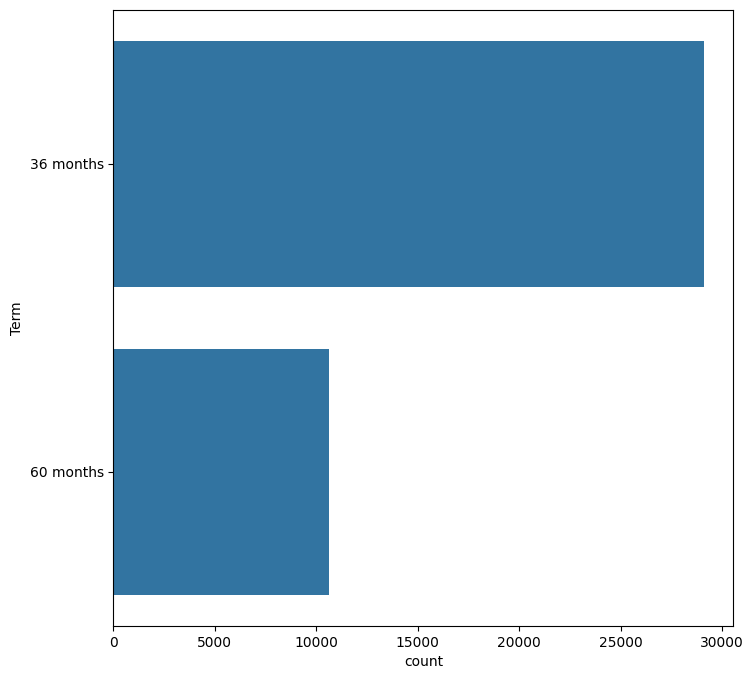

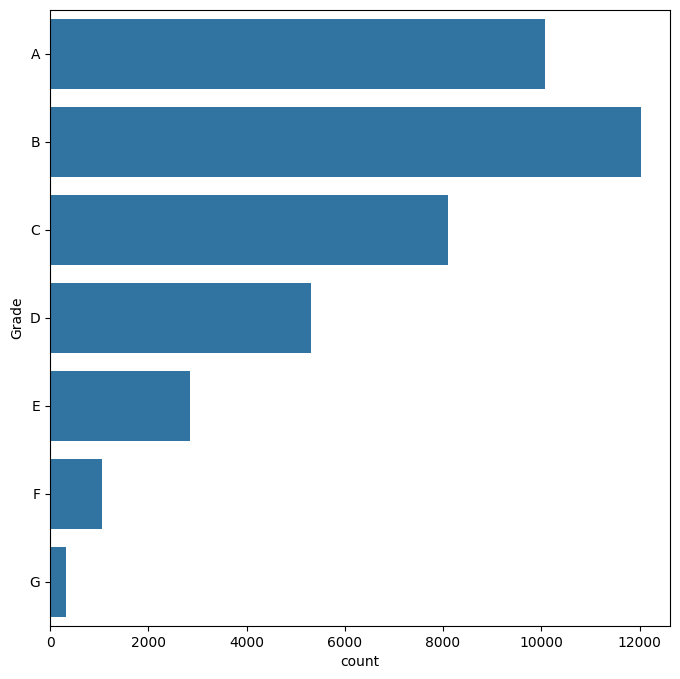

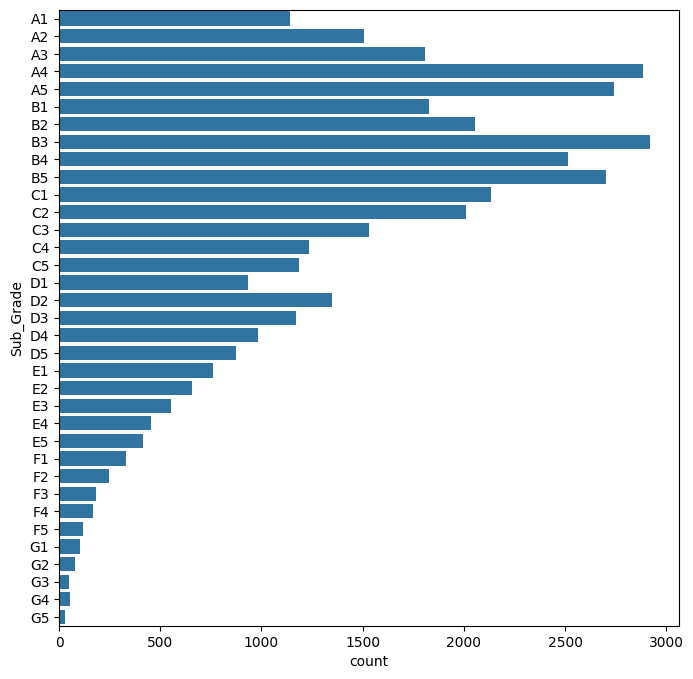

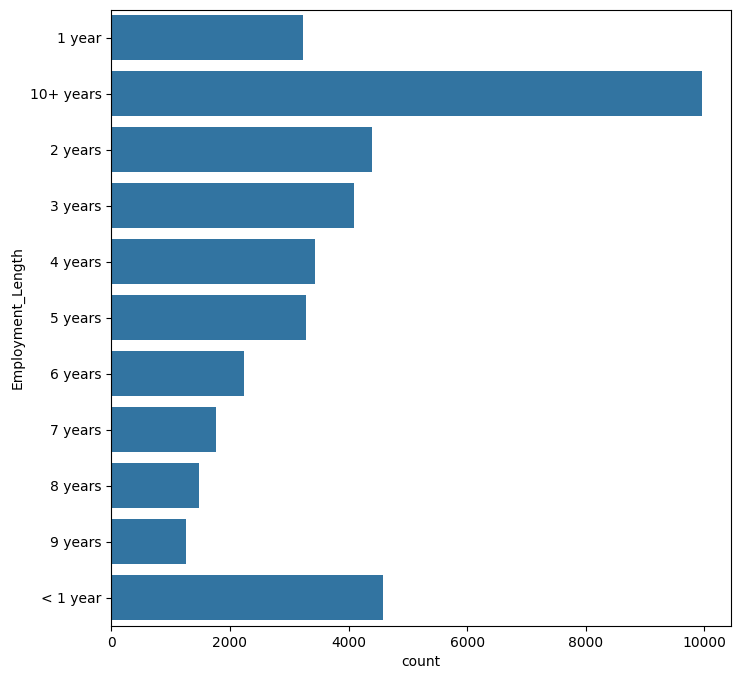

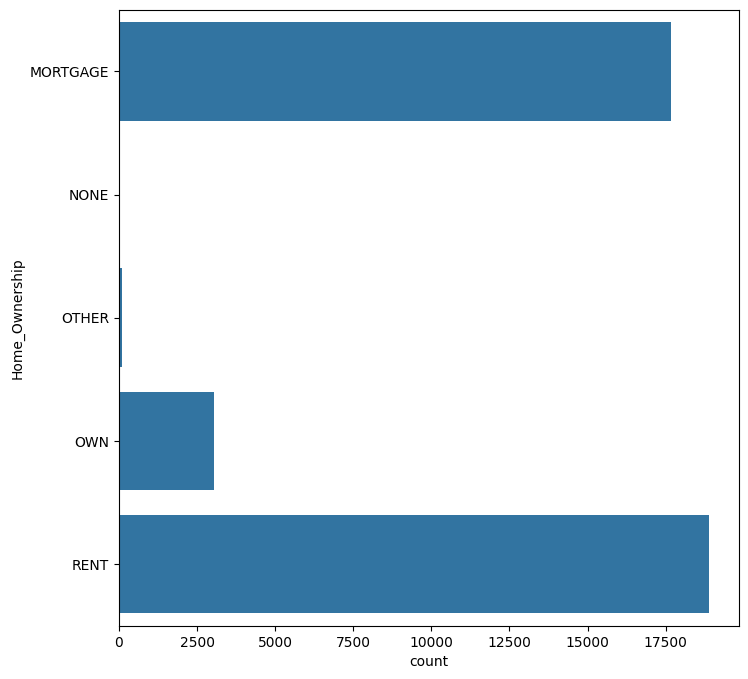

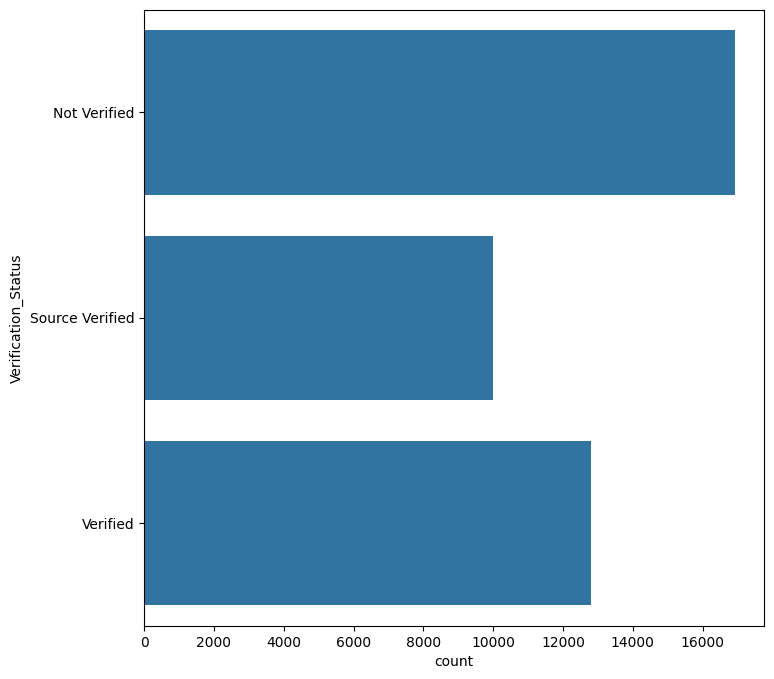

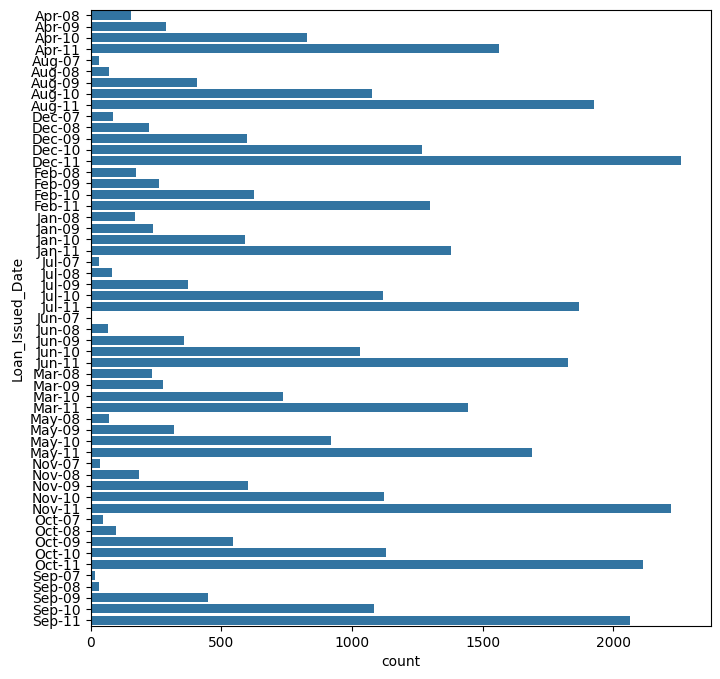

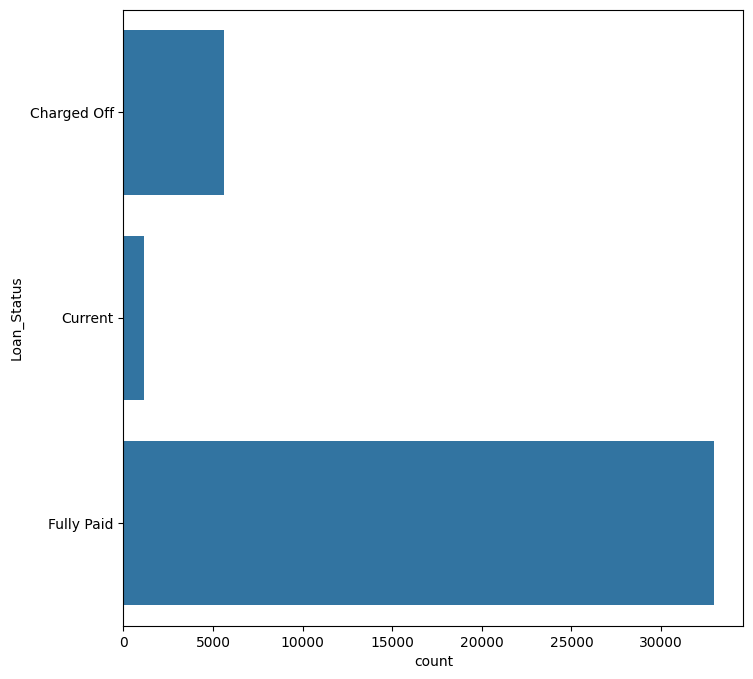

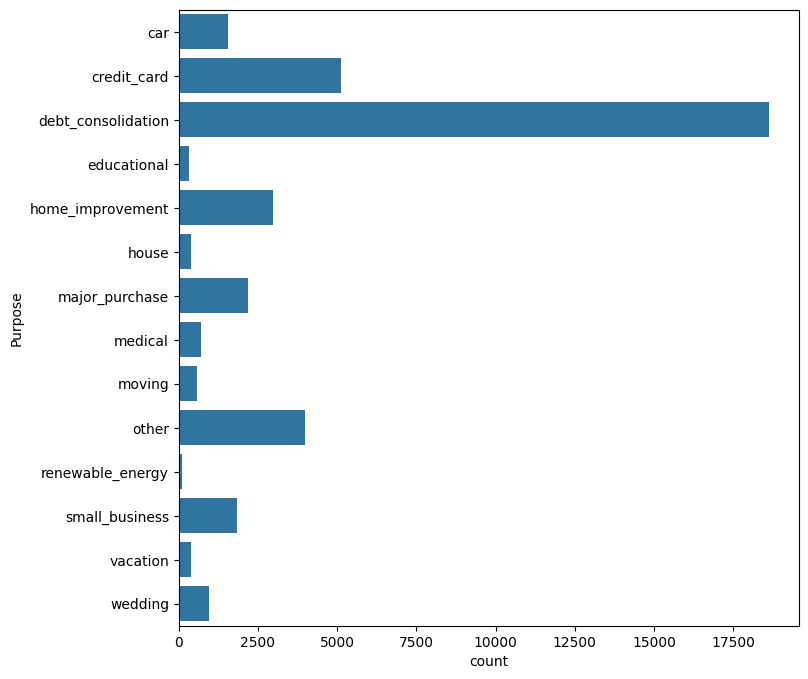

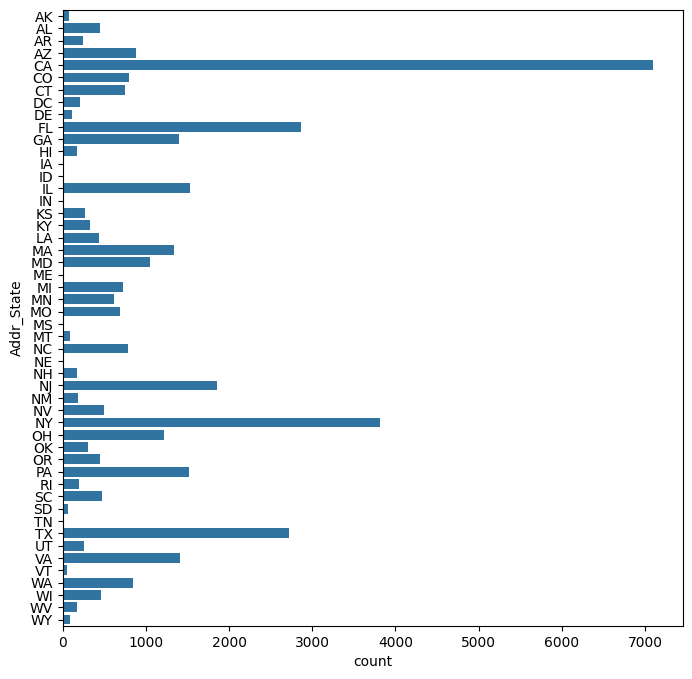

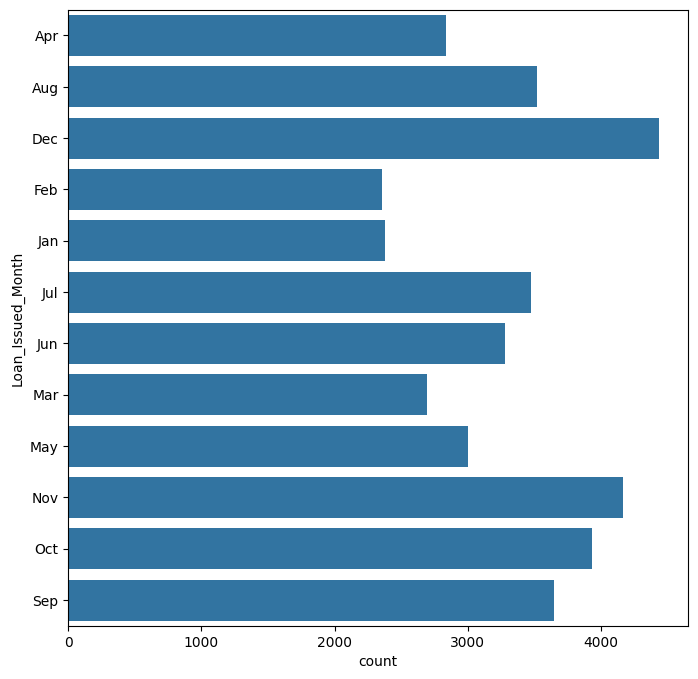

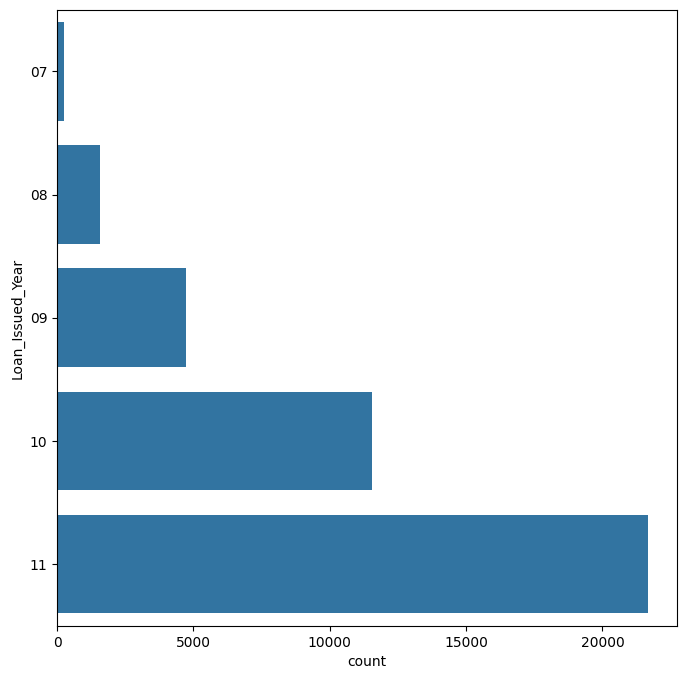

In [278]:
for col in cat_cols:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.countplot(y = loan[col])
    plt.show()

### Categorical - Term

| Home_Ownership | count |
| :- | --- |
| RENT | 18899 |
| MORTGAGE | 17659 |
| OWN | 3058 |
| OTHER | 98 |
| NONE | 3 |

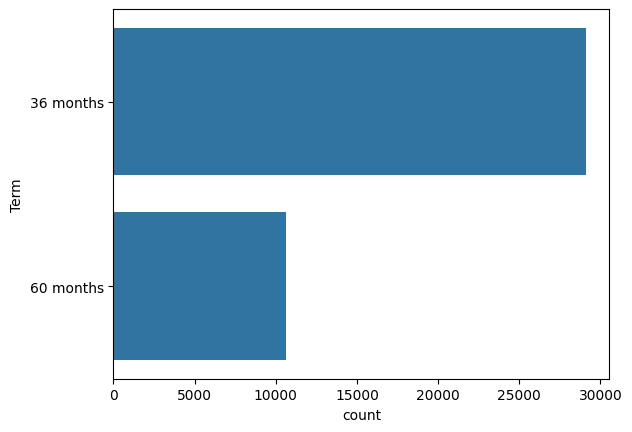

In [279]:
md_vc(loan.Home_Ownership)
ax = sns.countplot(y=loan.Term, order=loan.Term.value_counts().index)
plt.show()

### Categorical - Home_Ownership

In [280]:
md_vc(loan.Home_Ownership)

| Home_Ownership | count |
| :- | --- |
| RENT | 18899 |
| MORTGAGE | 17659 |
| OWN | 3058 |
| OTHER | 98 |
| NONE | 3 |

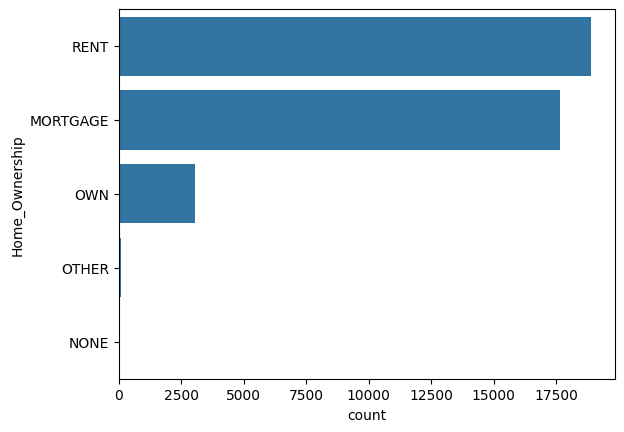

In [281]:
ax = sns.countplot(y=loan.Home_Ownership, order=loan.Home_Ownership.value_counts().index)
plt.show()

##### Observation:
- There are more customers from rented houses followed by mortgated.
- Very few clients come from Other and None types.

#### Categorical - Loan_Status

In [282]:
md_vc(loan.Loan_Status)

| Loan_Status | count |
| :- | --- |
| Fully Paid | 32950 |
| Charged Off | 5627 |
| Current | 1140 |

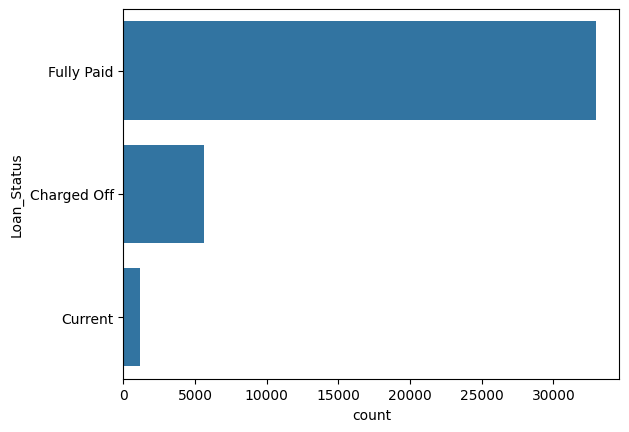

In [283]:
ax = sns.countplot(y=loan.Loan_Status, order=loan.Loan_Status.value_counts().index)
plt.show()

#### Categorical - Grade and Subgrades

In [284]:
md_vc(loan.Grade)

| Grade | count |
| :- | --- |
| B | 12020 |
| A | 10085 |
| C | 8098 |
| D | 5307 |
| E | 2842 |
| F | 1049 |
| G | 316 |

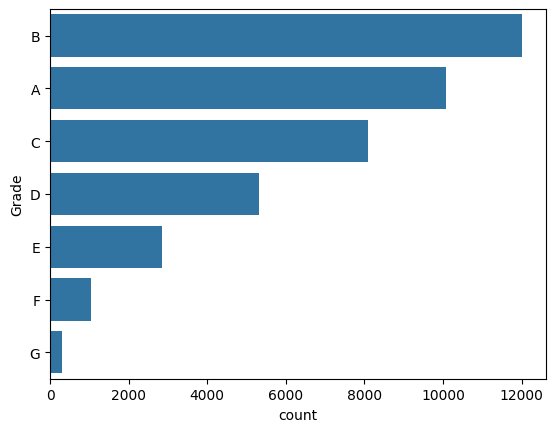

In [285]:
ax = sns.countplot(y=loan.Grade, order=loan.Grade.value_counts().index)
plt.show()

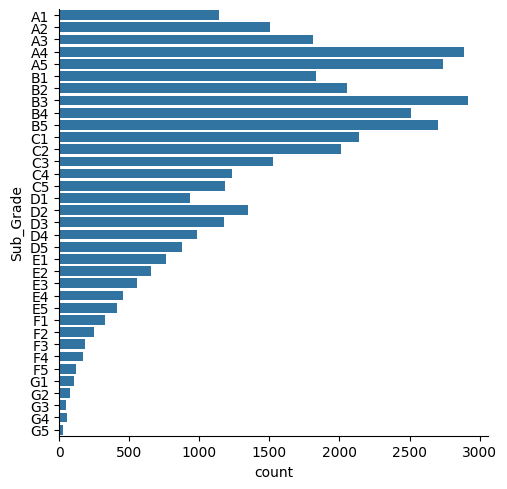

In [286]:
sns.catplot(data = loan, y = 'Sub_Grade', kind = 'count')
plt.show()

##### Observation:
- Members with Grades B, A and, C top the list with insignificant change among the sub-grades.

#### Categorical - Employment_Length

In [287]:
md_vc(loan.Employment_Length)

| Employment_Length | count |
| :- | --- |
| 10+ years | 9954 |
| < 1 year | 4583 |
| 2 years | 4388 |
| 3 years | 4095 |
| 4 years | 3436 |
| 5 years | 3282 |
| 1 year | 3240 |
| 6 years | 2229 |
| 7 years | 1773 |
| 8 years | 1479 |
| 9 years | 1258 |

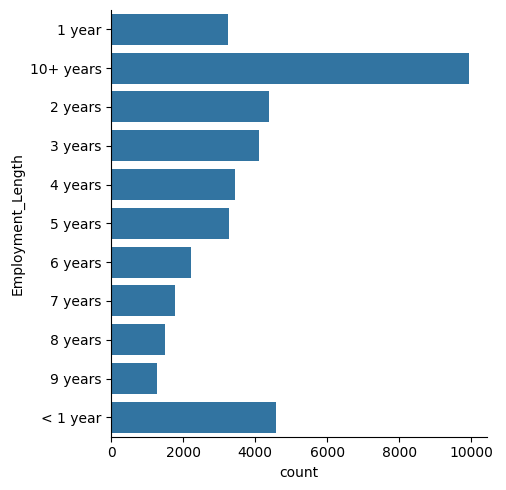

In [288]:
sns.catplot(data = loan, y = 'Employment_Length', kind = 'count')
plt.show()

##### Observation
- People with '10+ years' of experience were given more loans. This could be due to the fact that it is a bracket category
      which hold anybody who are 10 and more years experienced. The same is confirmed by the '< 1 year' category.
- Considering the above fact, it is appearing than people with lesser experience tend to borrow more.

#### Categorical - Purpose

In [289]:
md_vc(loan.Purpose)

| Purpose | count |
| :- | --- |
| debt_consolidation | 18641 |
| credit_card | 5130 |
| other | 3993 |
| home_improvement | 2976 |
| major_purchase | 2187 |
| small_business | 1828 |
| car | 1549 |
| wedding | 947 |
| medical | 693 |
| moving | 583 |
| house | 381 |
| vacation | 381 |
| educational | 325 |
| renewable_energy | 103 |

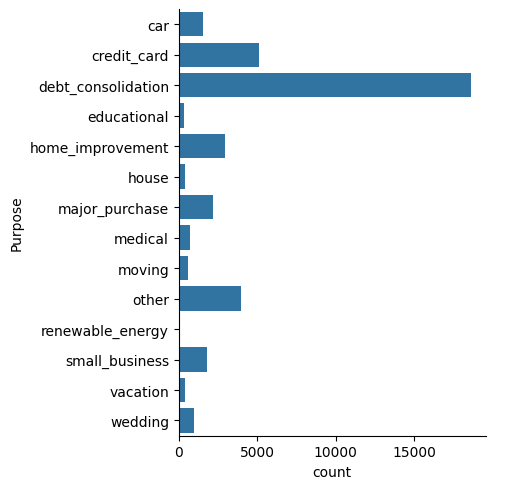

In [290]:
sns.catplot(data = loan, y = 'Purpose', kind = 'count')
plt.show()

##### Observation:
- More loans are issued towards debt_collection followed by credit_card

#### Categorical - Loan_Issued_Year

In [291]:
md_vc(loan.Loan_Issued_Year)

| Loan_Issued_Year | count |
| :- | --- |
| 11 | 21656 |
| 10 | 11532 |
| 09 | 4716 |
| 08 | 1562 |
| 07 | 251 |

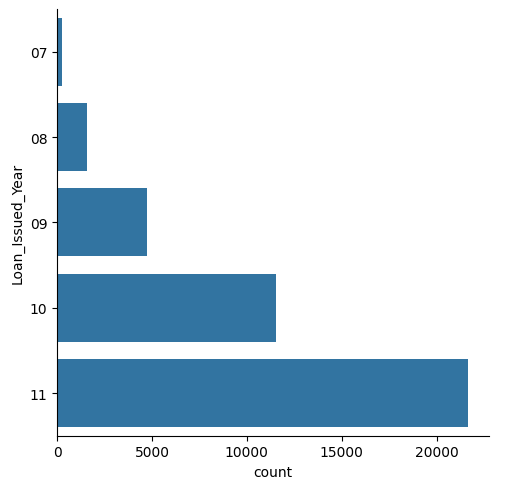

In [292]:
sns.catplot(data = loan, y = 'Loan_Issued_Year', kind = 'count')
plt.show()

##### Observation
- Number of borrowers are increasing with years
- The maximum number of loans were issued in the year 2011.
- This could be triggered by the Real-estate related recession and the job losses that hit in 2008 and that could've set the borrowing cycle on.

#### Categorical - Loan_Issued_Month

In [293]:
md_vc(loan.Loan_Issued_Month)

| Loan_Issued_Month | count |
| :- | --- |
| Dec | 4433 |
| Nov | 4167 |
| Oct | 3934 |
| Sep | 3648 |
| Aug | 3518 |
| Jul | 3476 |
| Jun | 3279 |
| May | 2999 |
| Apr | 2834 |
| Mar | 2692 |
| Jan | 2379 |
| Feb | 2358 |

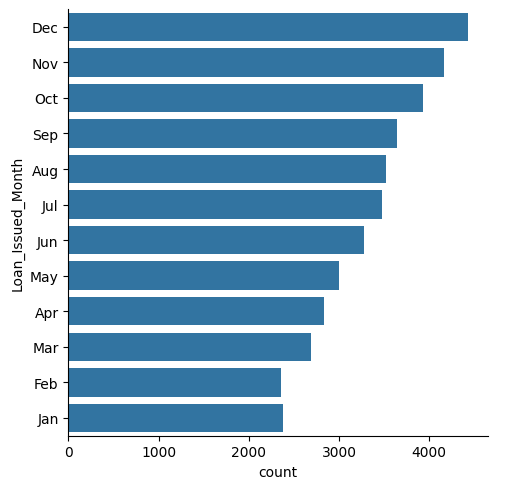

In [294]:
loan.Loan_Issued_Month = pd.Series(loan.Loan_Issued_Month).astype(str)
sns.catplot(data = loan, y = 'Loan_Issued_Month', kind = 'count')
plt.show()

##### Observation:
- More loans are taken towards the end of the year
- This period usually coincides with the holiday season. This is not the reason mentioned in the [Purpose](#Categorical-Purpose) section.

#### Categorical - Addr_State

In [295]:
md_vc(loan.Addr_State)

| Addr_State | count |
| :- | --- |
| CA | 7099 |
| NY | 3812 |
| FL | 2866 |
| TX | 2727 |
| NJ | 1850 |
| IL | 1525 |
| PA | 1517 |
| VA | 1407 |
| GA | 1398 |
| MA | 1340 |
| OH | 1223 |
| MD | 1049 |
| AZ | 879 |
| WA | 840 |
| CO | 792 |
| NC | 788 |
| CT | 751 |
| MI | 720 |
| MO | 686 |
| MN | 615 |
| NV | 497 |
| SC | 472 |
| WI | 460 |
| AL | 452 |
| OR | 451 |
| LA | 436 |
| KY | 325 |
| OK | 299 |
| KS | 271 |
| UT | 258 |
| AR | 245 |
| DC | 214 |
| RI | 198 |
| NM | 189 |
| WV | 177 |
| HI | 174 |
| NH | 171 |
| DE | 114 |
| MT | 85 |
| WY | 83 |
| AK | 80 |
| SD | 64 |
| VT | 54 |
| MS | 19 |
| TN | 17 |
| IN | 9 |
| ID | 6 |
| NE | 5 |
| IA | 5 |
| ME | 3 |

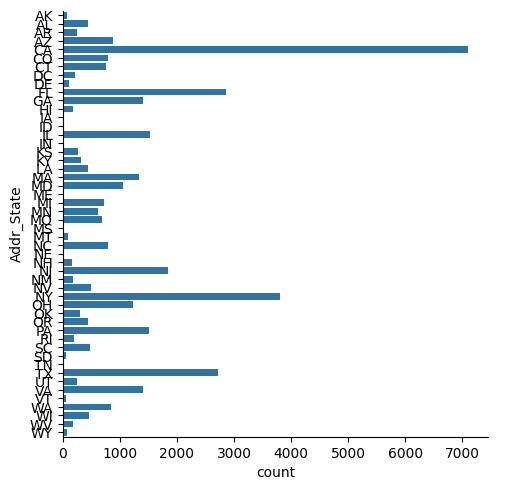

In [296]:
sns.catplot(data = loan, y = 'Addr_State', kind = 'count')
plt.show()

##### Observation:
- California, New York, Floride and Texas seems to have more borrowers.
- States that has more population ranks in top in this list.

#### Numerical - subplots

**Loan_Amount**

count    39717.000000
mean     11219.443815
std       7456.670694
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: Loan_Amount, dtype: float64


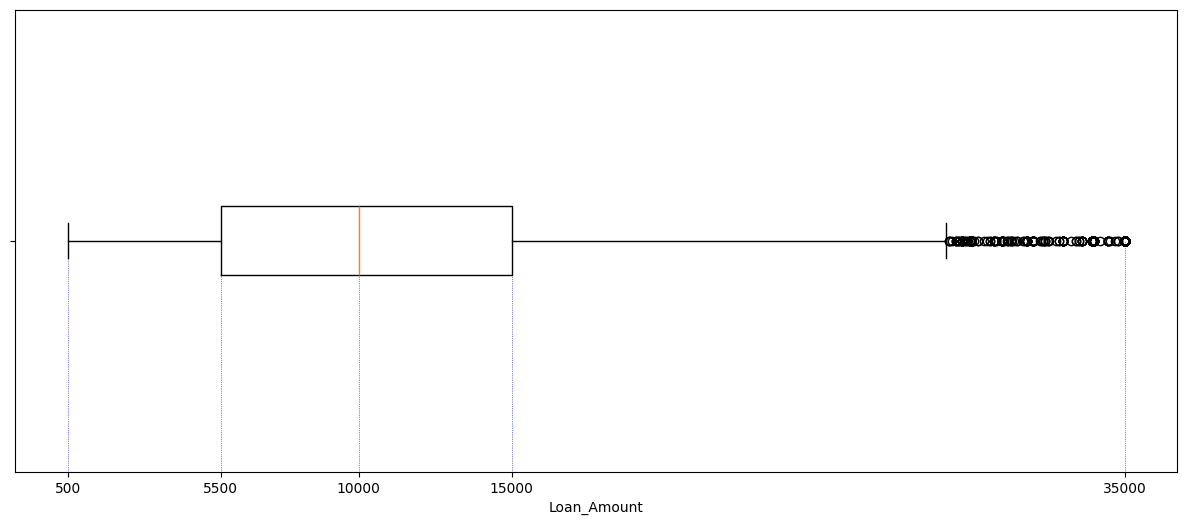

***

**Funded_Amount**

count    39717.000000
mean     10947.713196
std       7187.238670
min        500.000000
25%       5400.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: Funded_Amount, dtype: float64


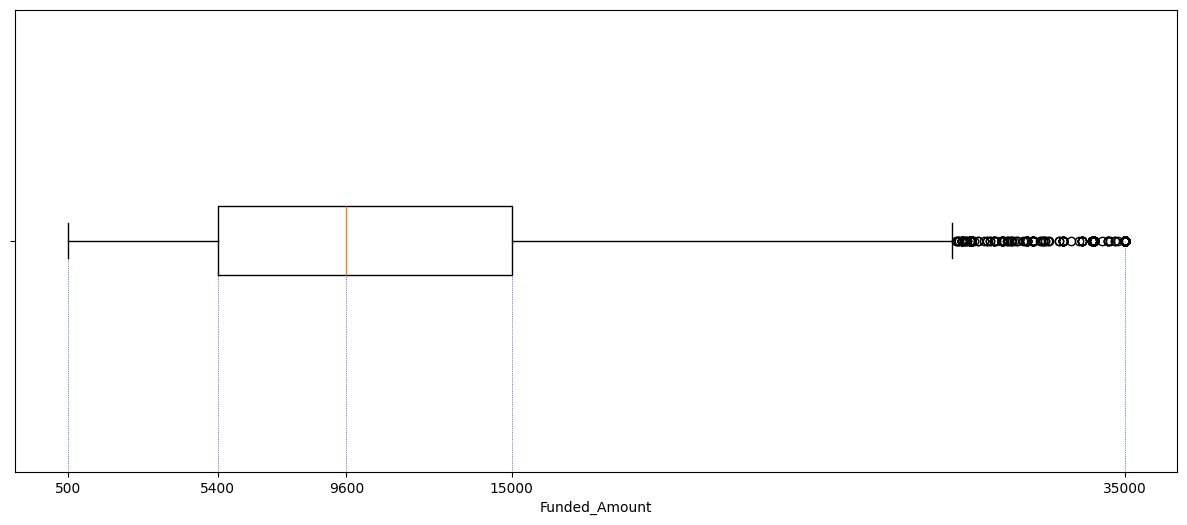

***

**Interest_Rate**

count    39717.000000
mean        12.021177
std          3.724825
min          5.420000
25%          9.250000
50%         11.860000
75%         14.590000
max         24.590000
Name: Interest_Rate, dtype: float64


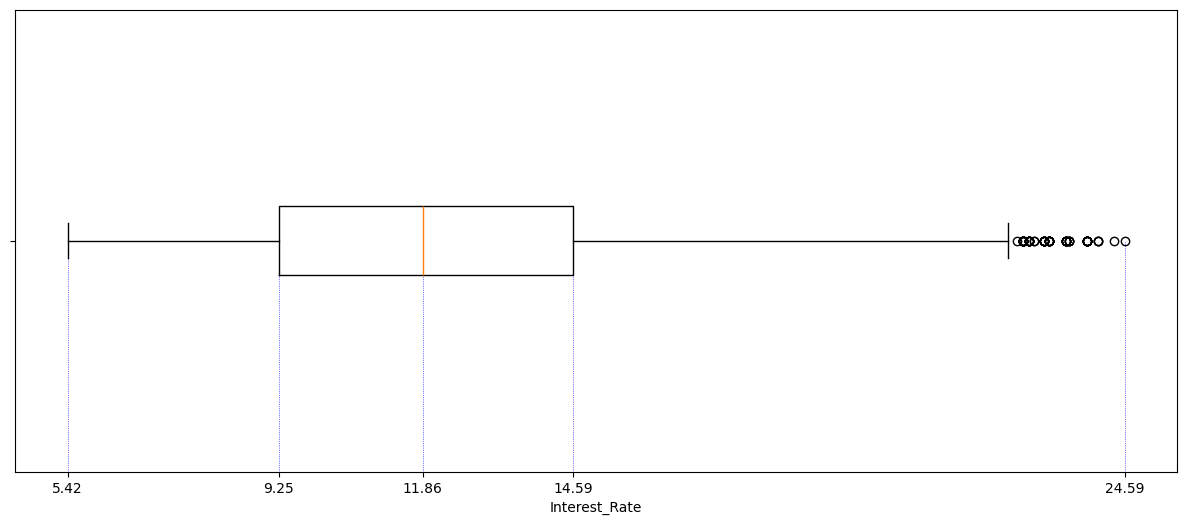

***

**Installment**

count    39717.000000
mean       324.561922
std        208.874874
min         15.690000
25%        167.020000
50%        280.220000
75%        430.780000
max       1305.190000
Name: Installment, dtype: float64


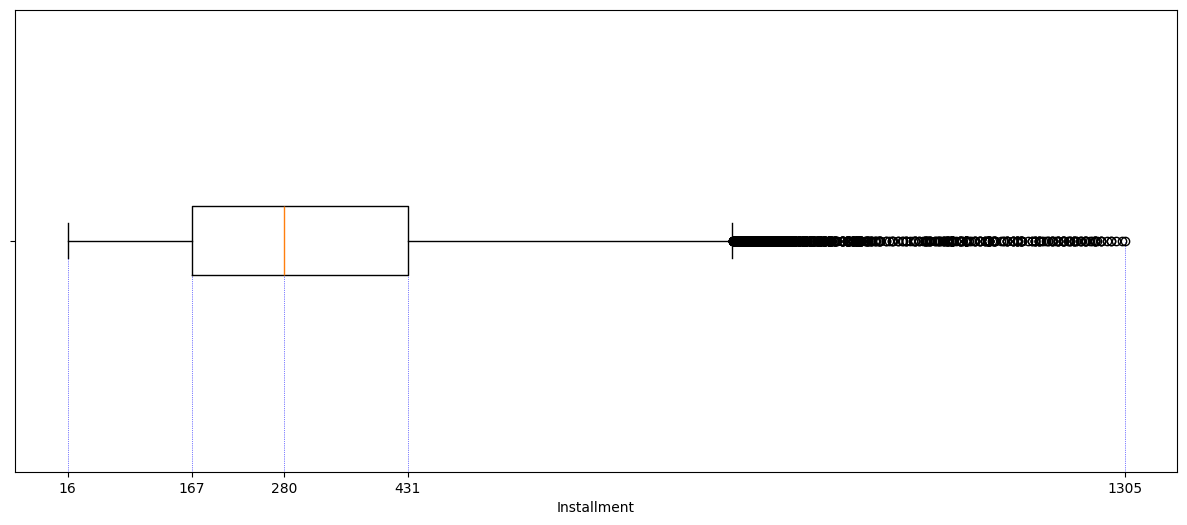

***

**Annual_Income**

count    3.971700e+04
mean     6.896893e+04
std      6.379377e+04
min      4.000000e+03
25%      4.040400e+04
50%      5.900000e+04
75%      8.230000e+04
max      6.000000e+06
Name: Annual_Income, dtype: float64


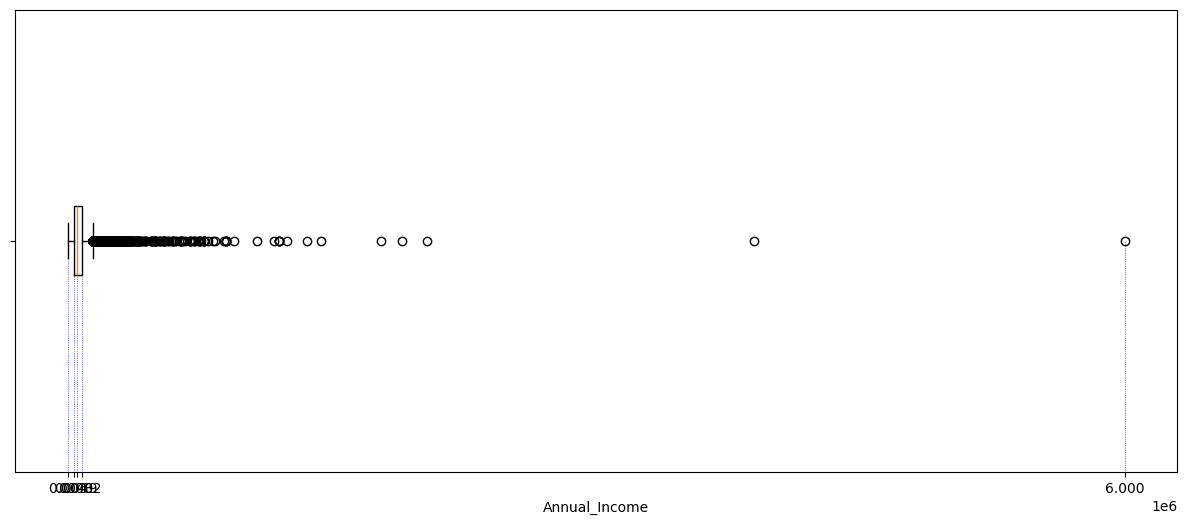

***

**Debt_to_Income_Ratio**

count    39717.000000
mean        13.315130
std          6.678594
min          0.000000
25%          8.170000
50%         13.400000
75%         18.600000
max         29.990000
Name: Debt_to_Income_Ratio, dtype: float64


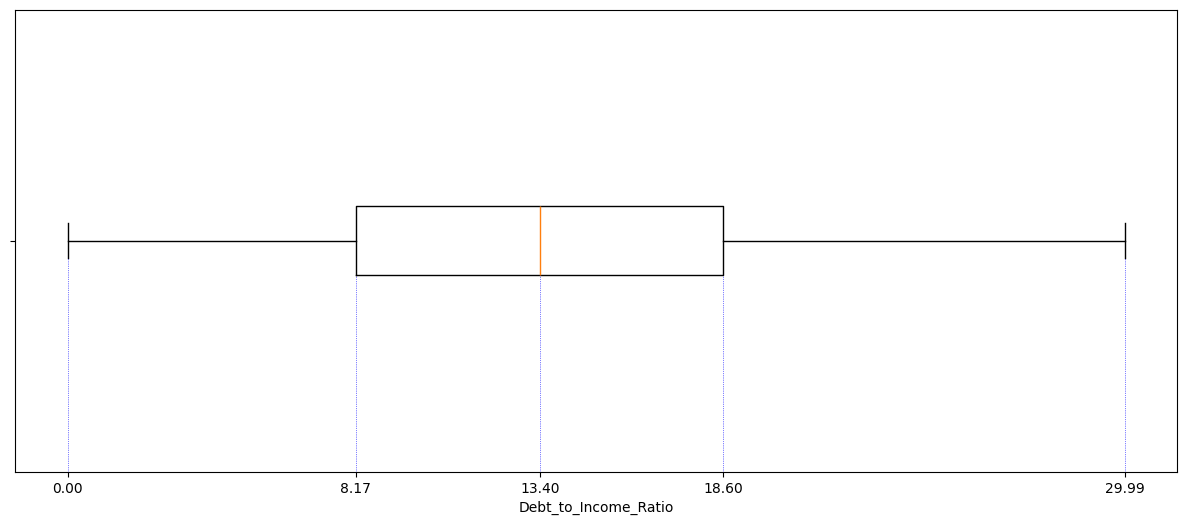

***

**Inquiries_Last_6mths**

count    39717.000000
mean         0.869200
std          1.070219
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: Inquiries_Last_6mths, dtype: float64


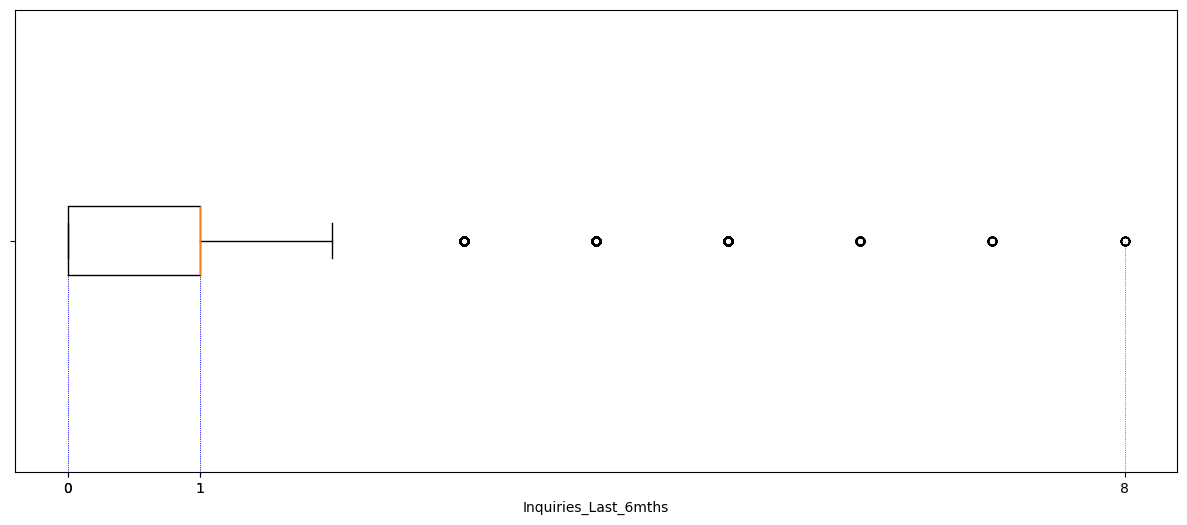

***

**Open_Credit_Lines**

count    39717.000000
mean         9.294408
std          4.400282
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: Open_Credit_Lines, dtype: float64


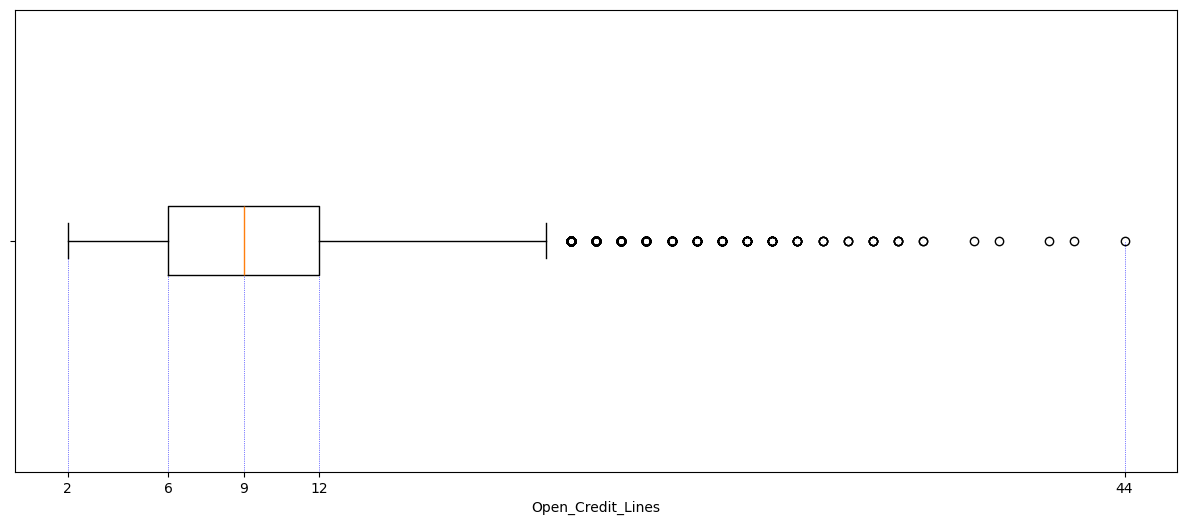

***

**Pub_Record_Derogatory**

count    39717.000000
mean         0.055065
std          0.237200
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: Pub_Record_Derogatory, dtype: float64


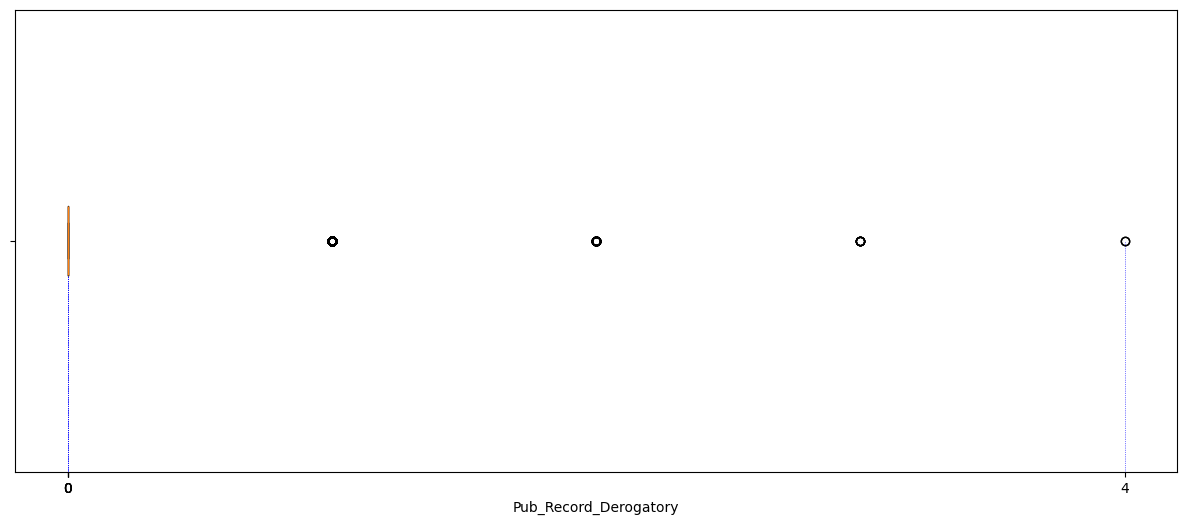

***

**Revolving_Balance**

count     39717.000000
mean      13382.528086
std       15885.016641
min           0.000000
25%        3703.000000
50%        8850.000000
75%       17058.000000
max      149588.000000
Name: Revolving_Balance, dtype: float64


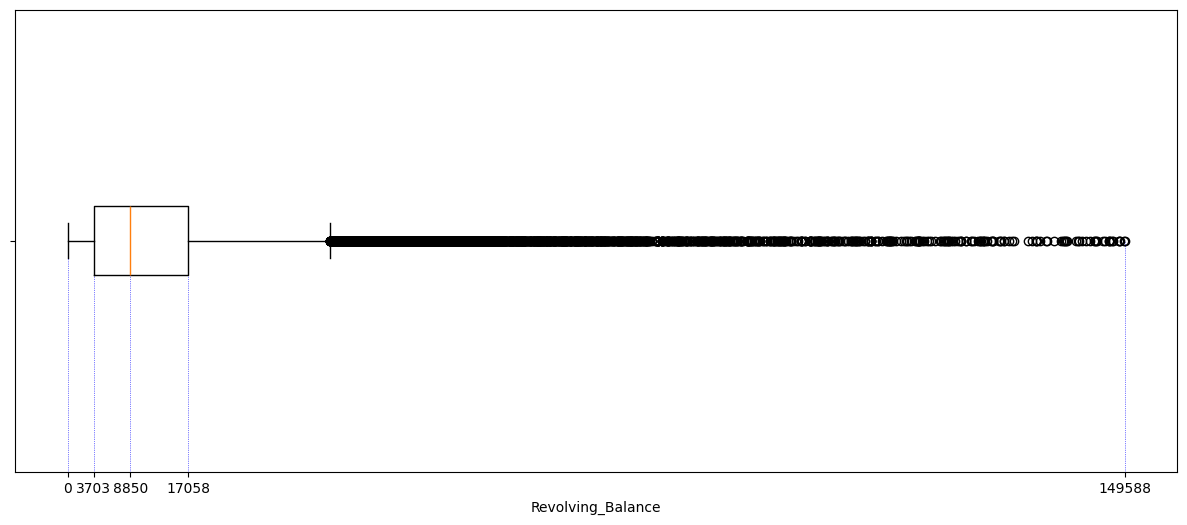

***

**Revolving_Line_Util**

count    39717.000000
mean        48.832741
std         28.314798
min          0.000000
25%         25.500000
50%         49.300000
75%         72.300000
max         99.900000
Name: Revolving_Line_Util, dtype: float64


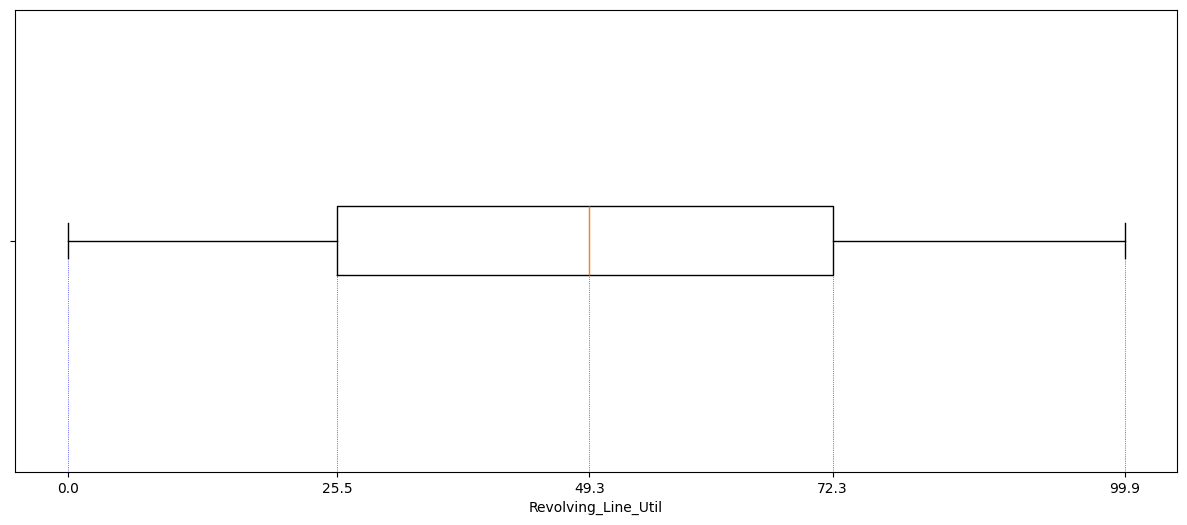

***

**Total_Credit_Line**

count    39717.000000
mean        22.088828
std         11.401709
min          2.000000
25%         13.000000
50%         20.000000
75%         29.000000
max         90.000000
Name: Total_Credit_Line, dtype: float64


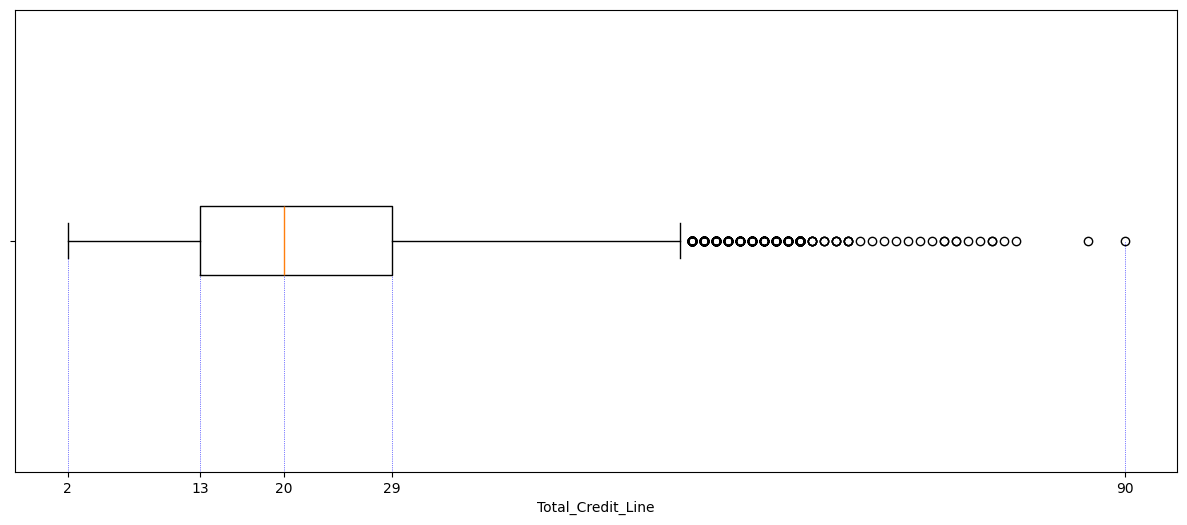

***

**Outstanding_Principle**

count    39717.000000
mean        51.227887
std        375.172839
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       6311.470000
Name: Outstanding_Principle, dtype: float64


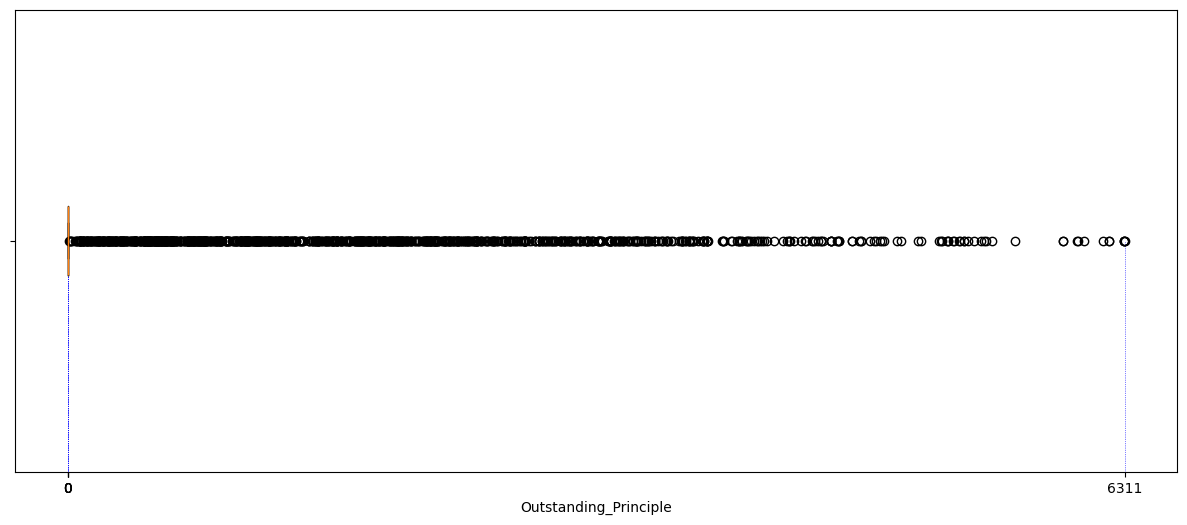

***

**Total_Payment**

count    39717.000000
mean     12153.596544
std       9042.040766
min          0.000000
25%       5576.930000
50%       9899.640319
75%      16534.433040
max      58563.679930
Name: Total_Payment, dtype: float64


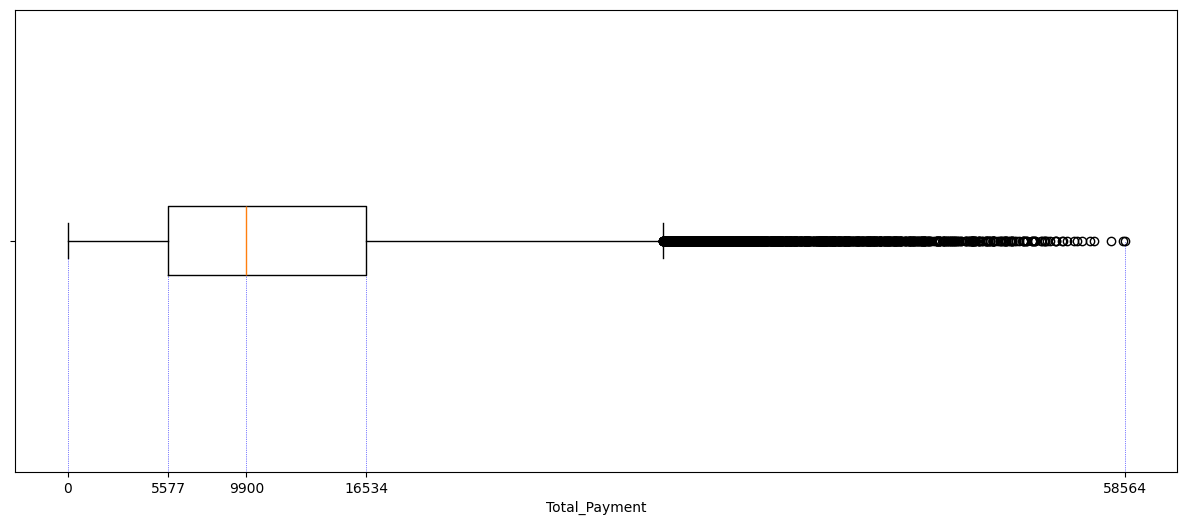

***

**total_pymnt_inv**

count    39717.000000
mean     11567.149118
std       8942.672613
min          0.000000
25%       5112.310000
50%       9287.150000
75%      15798.810000
max      58563.680000
Name: total_pymnt_inv, dtype: float64


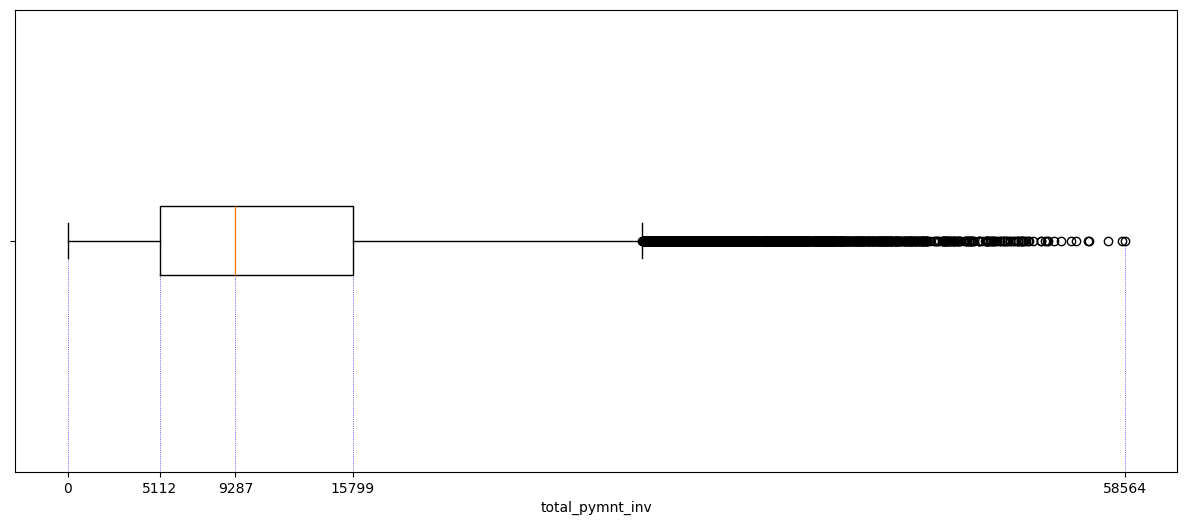

***

**Total_Received_Principle**

count    39717.000000
mean      9793.348813
std       7065.522127
min          0.000000
25%       4600.000000
50%       8000.000000
75%      13653.260000
max      35000.020000
Name: Total_Received_Principle, dtype: float64


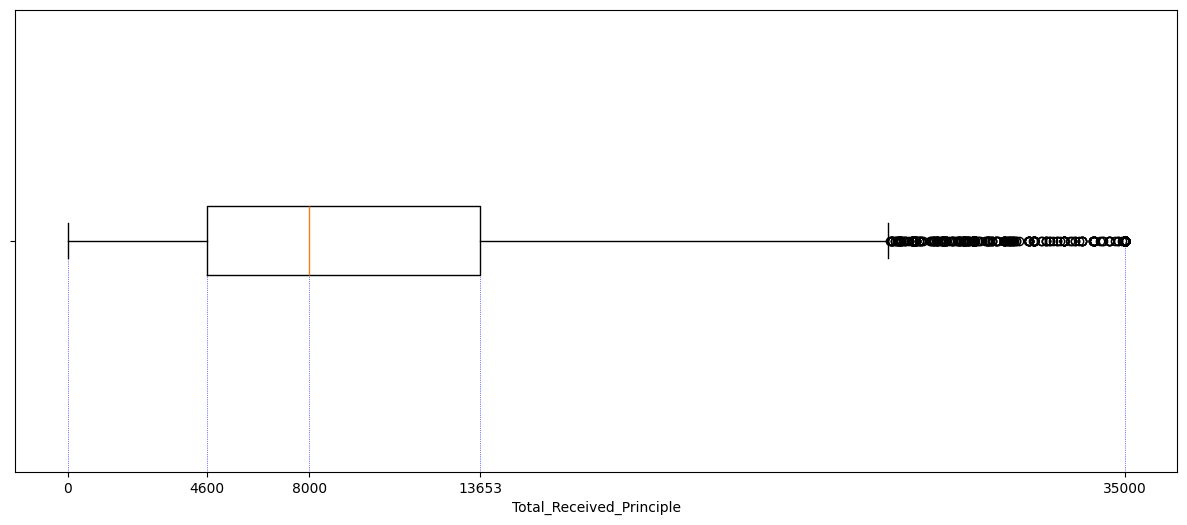

***

**Total_Recived_Interest**

count    39717.000000
mean      2263.663172
std       2608.111964
min          0.000000
25%        662.180000
50%       1348.910000
75%       2833.400000
max      23563.680000
Name: Total_Recived_Interest, dtype: float64


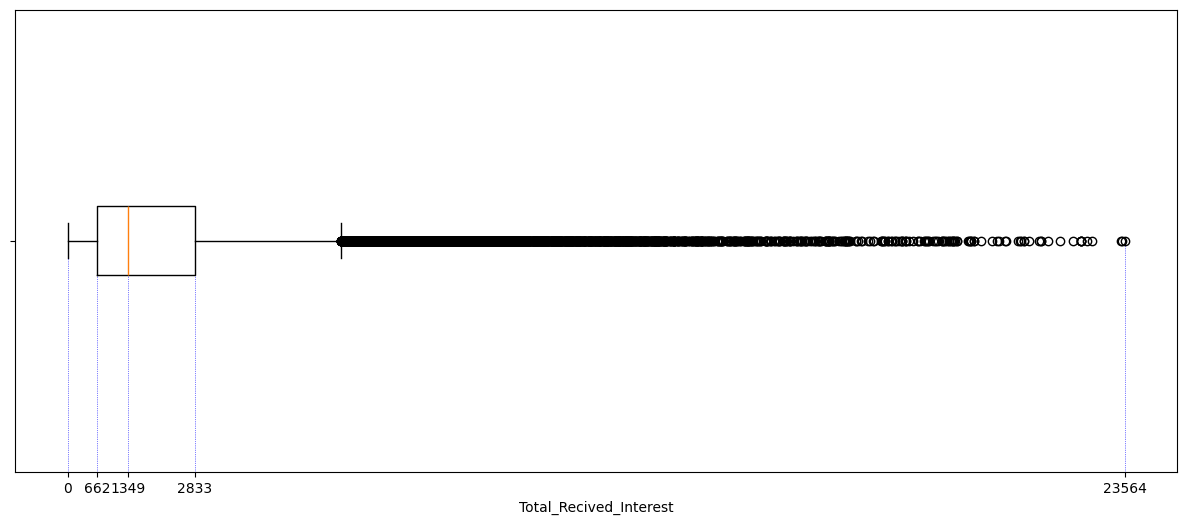

***

**Pub_Record_Bankruptcies**

count    39717.000000
mean         0.042501
std          0.202603
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: Pub_Record_Bankruptcies, dtype: float64


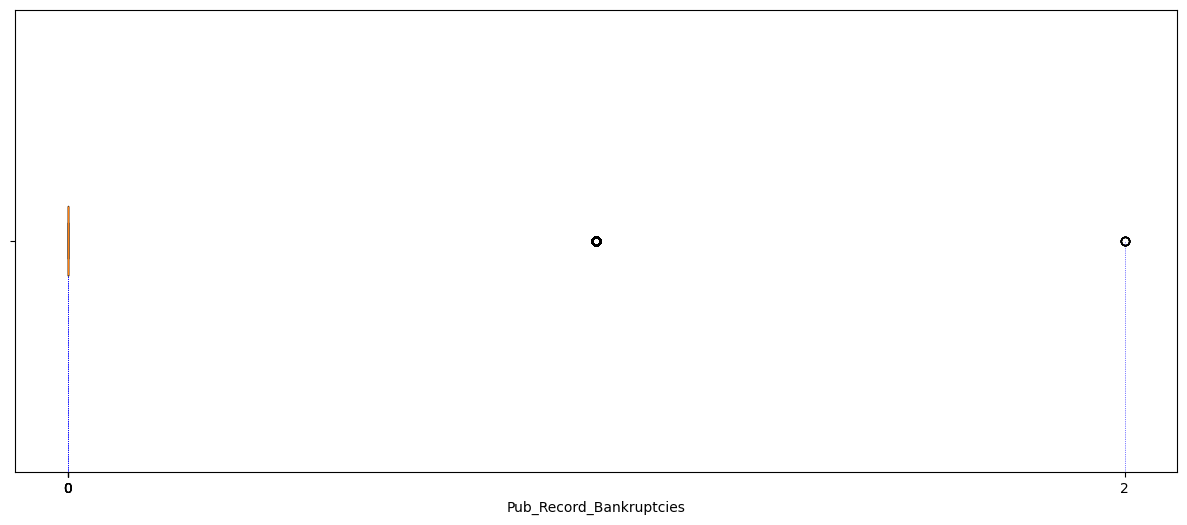

***

**Term_in_Months**

count    39717.000000
mean        42.418007
std         10.622815
min         36.000000
25%         36.000000
50%         36.000000
75%         60.000000
max         60.000000
Name: Term_in_Months, dtype: float64


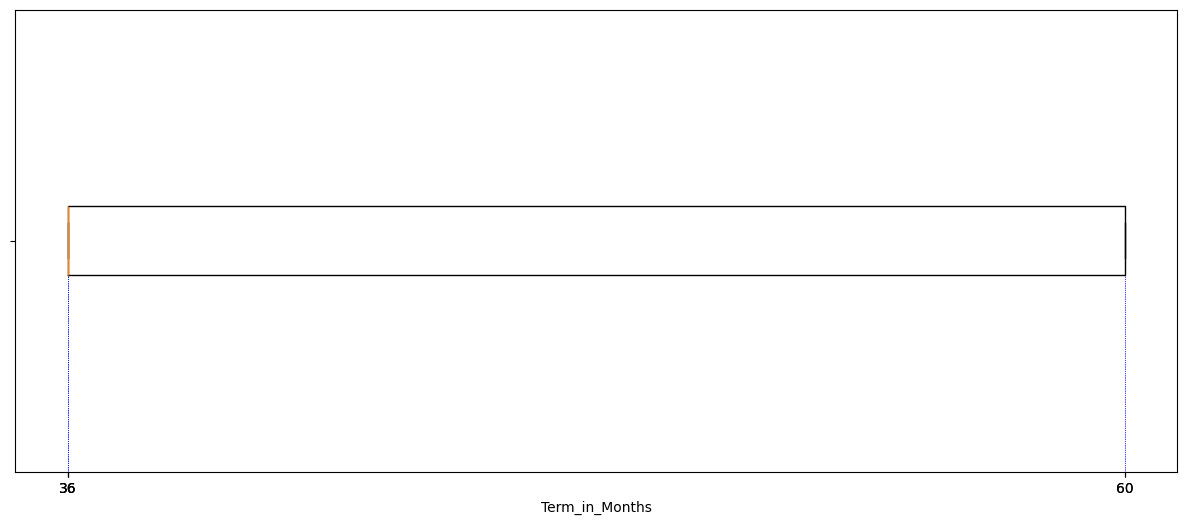

***

**Loan_Status_In_Num**

count    39717.000000
mean        14.167737
std         34.872332
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        100.000000
Name: Loan_Status_In_Num, dtype: float64


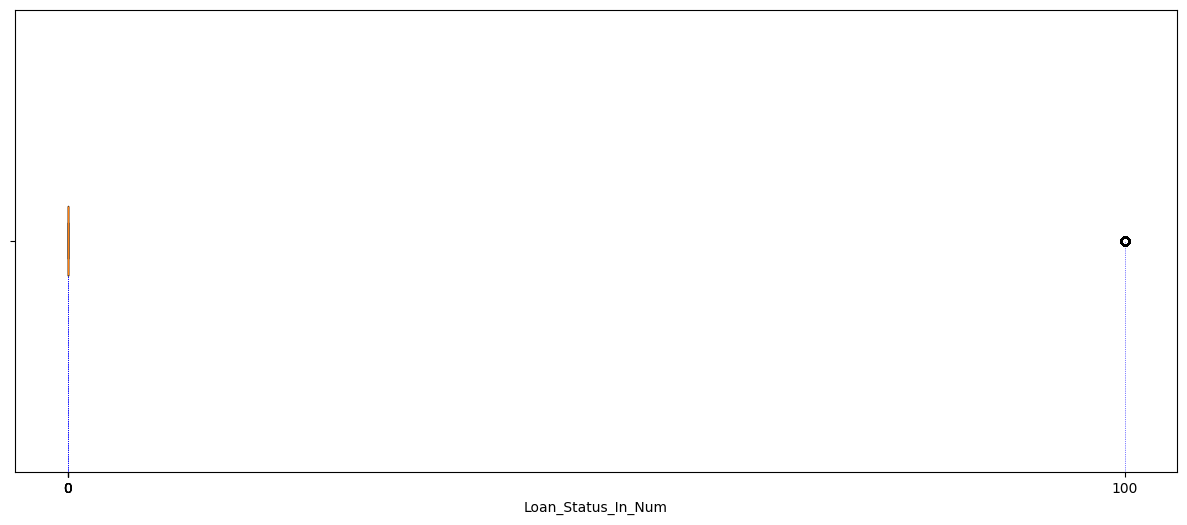

***

**Monthly_Income**

count     39717.000000
mean       5747.410531
std        5316.147149
min         333.333333
25%        3367.000000
50%        4916.666667
75%        6858.333333
max      500000.000000
Name: Monthly_Income, dtype: float64


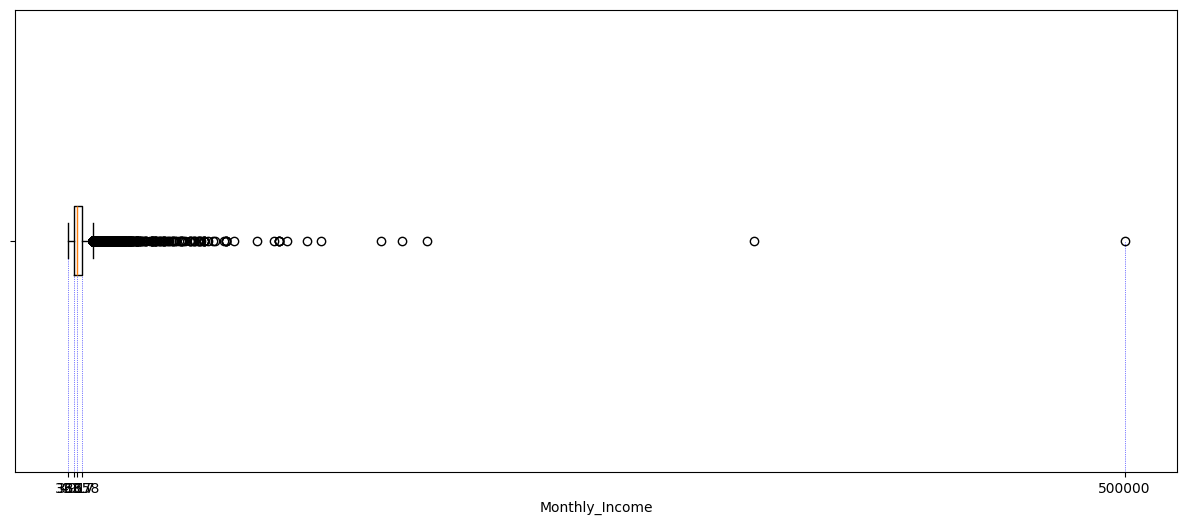

***

**Income_Installment_Ratio**

count    39717.000000
mean         0.065801
std          0.039984
min          0.000289
25%          0.035248
50%          0.058005
75%          0.088405
max          0.320262
Name: Income_Installment_Ratio, dtype: float64


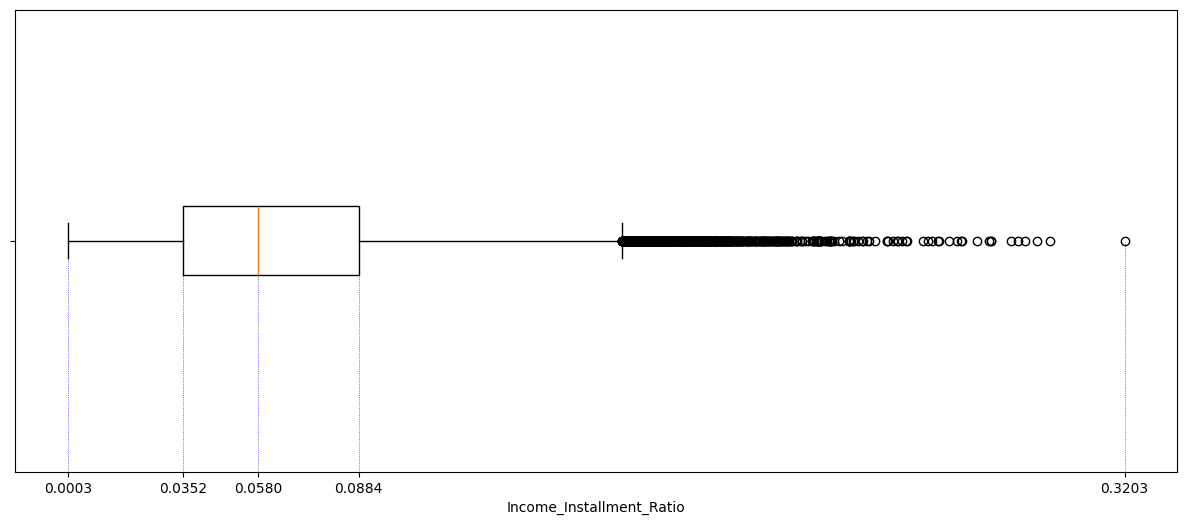

***

In [297]:
for col in num_cols:
    md(f'**{col}**')
    print(loan[col].describe())
    box_plot(loan, col=col, yticklabels=[], threshold=loan[col].max())
    md('***')
    

#### Numerical - Loan_Amount

count    39717.000000
mean     11219.443815
std       7456.670694
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: Loan_Amount, dtype: float64


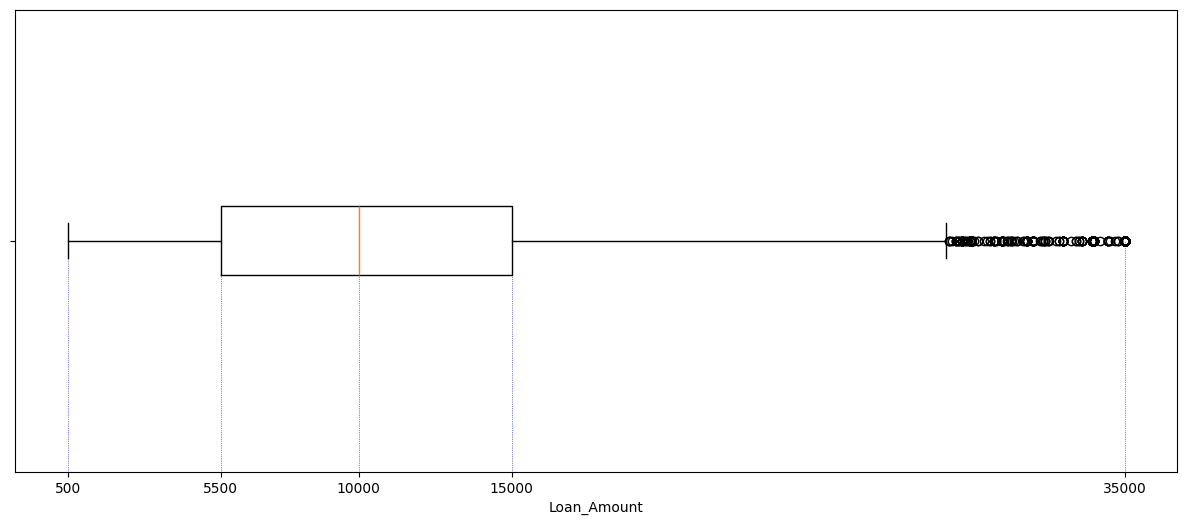

In [298]:
col = 'Loan_Amount'
print(loan[col].describe())
box_plot(loan, col=col, yticklabels=[], threshold=loan[col].max())

##### Observation
- Customers borrowed as minimum as \\$500 and as high as \\$35,000
- On an average, most customers borrowed in the range of \\$5,500 and \\$15,000
- The median stays at \\$10,000

#### Numerical - Interest_Rate

count    39717.000000
mean        12.021177
std          3.724825
min          5.420000
25%          9.250000
50%         11.860000
75%         14.590000
max         24.590000
Name: Interest_Rate, dtype: float64


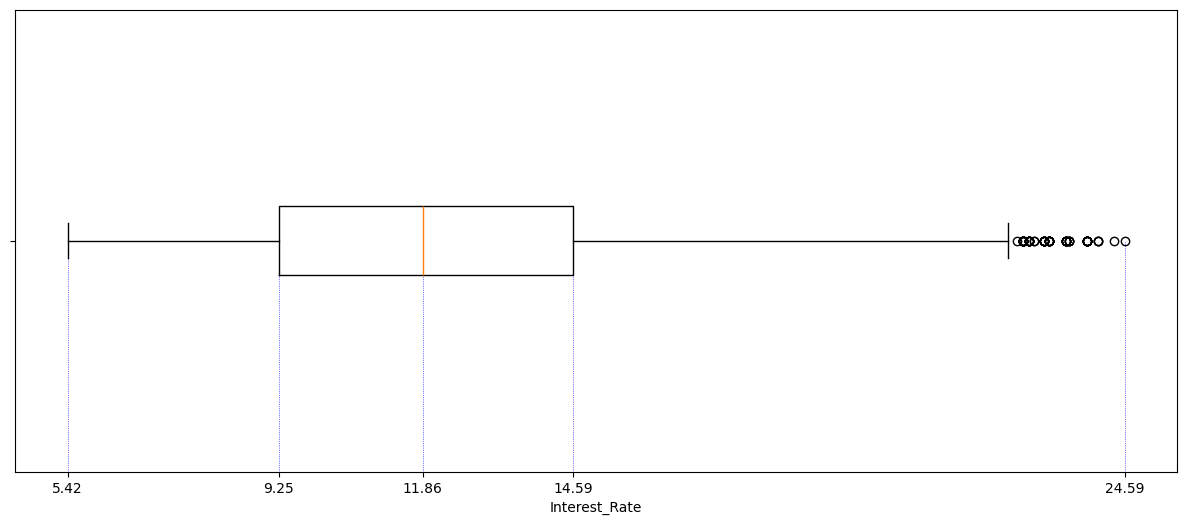

In [299]:
col = 'Interest_Rate'
print(loan[col].describe())
box_plot(loan, col=col, yticklabels=[], threshold=loan[col].max())

##### Observation:
- The hightest interest rate is 24.59%
- But most number of people were offered between 9.25 and 14.6%

#### Numerical - Annual_Income

count    3.971700e+04
mean     6.896893e+04
std      6.379377e+04
min      4.000000e+03
25%      4.040400e+04
50%      5.900000e+04
75%      8.230000e+04
max      6.000000e+06
Name: Annual_Income, dtype: float64


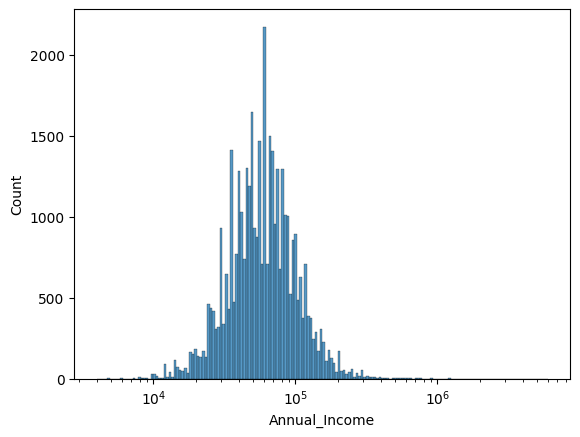

In [300]:
col = 'Annual_Income'
print(loan[col].describe())
sns.histplot(x=loan.Annual_Income, log_scale=True, )
plt.show()

##### Observation
- There are a large number of outliers in the salary with highest being \\$6Million and lowest being \\$4,000
- On an average, the salaries were between \\$40,000 and \\$82,000

***

### Bivariate Analysis - subplots

In [301]:
loan_def = loan[(loan['Loan_Status'] == 'Charged Off')]
loan_fp = loan[(loan['Loan_Status'] == 'Fully Paid')]
loan_noncurrent = [loan_fp, loan_def]
loan.groupby(by = 'Loan_Status', observed=False).Interest_Rate.describe()


,count,mean,std,min,25%,50%,75%,max
Loan_Status,,,,,,,,
Charged Off,5627.0,13.820432,3.654413,5.42,11.31,13.61,16.40,24.40
Current,1140.0,15.031465,3.600343,6.00,11.99,14.65,17.99,24.59
Fully Paid,32950.0,11.609761,3.599964,5.42,8.49,11.49,13.99,24.11


               count          mean          std     min      25%      50%  \
Loan_Status                                                                 
Charged Off   5627.0  12104.385108  8085.732038   900.0   5600.0  10000.0   
Current       1140.0  17053.991228  8651.052316  1000.0  12000.0  15825.0   
Fully Paid   32950.0  10866.455994  7199.629493   500.0   5200.0   9600.0   

                 75%      max  
Loan_Status                    
Charged Off  16500.0  35000.0  
Current      23000.0  35000.0  
Fully Paid   15000.0  35000.0  


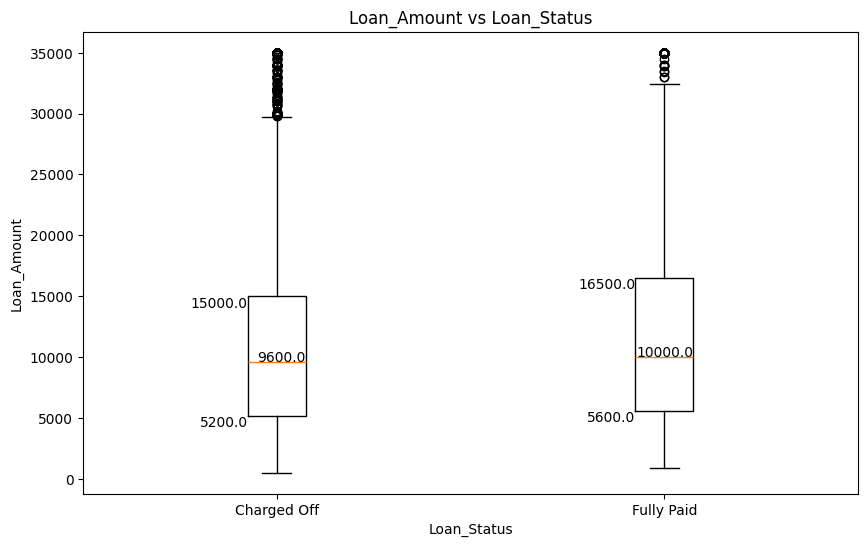

***

               count          mean          std     min      25%      50%  \
Loan_Status                                                                 
Charged Off   5627.0  11753.398792  7760.516335   900.0   5575.0  10000.0   
Current       1140.0  16485.701754  8183.567669  1000.0  11575.0  15225.0   
Fully Paid   32950.0  10618.520486  6956.047888   500.0   5050.0   9200.0   

                  75%      max  
Loan_Status                     
Charged Off  16000.00  35000.0  
Current      21281.25  35000.0  
Fully Paid   14500.00  35000.0  


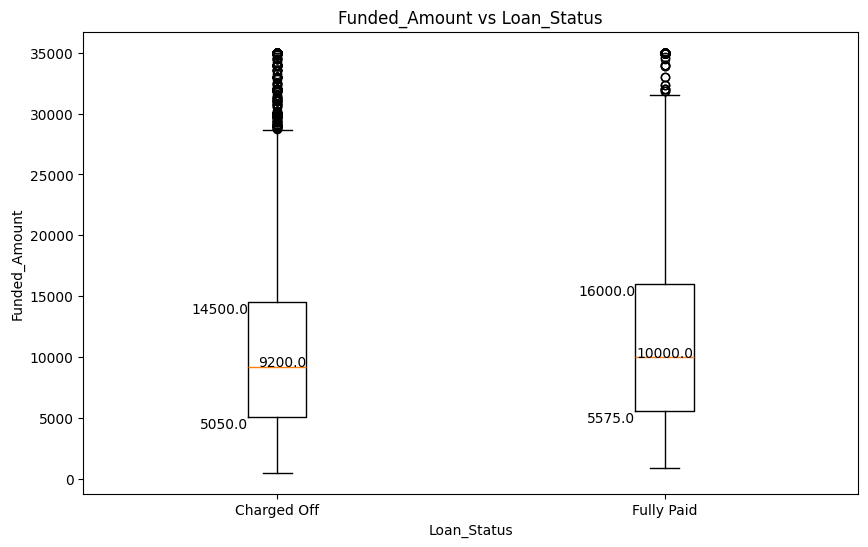

***

               count       mean       std   min    25%    50%    75%    max
Loan_Status                                                                
Charged Off   5627.0  13.820432  3.654413  5.42  11.31  13.61  16.40  24.40
Current       1140.0  15.031465  3.600343  6.00  11.99  14.65  17.99  24.59
Fully Paid   32950.0  11.609761  3.599964  5.42   8.49  11.49  13.99  24.11


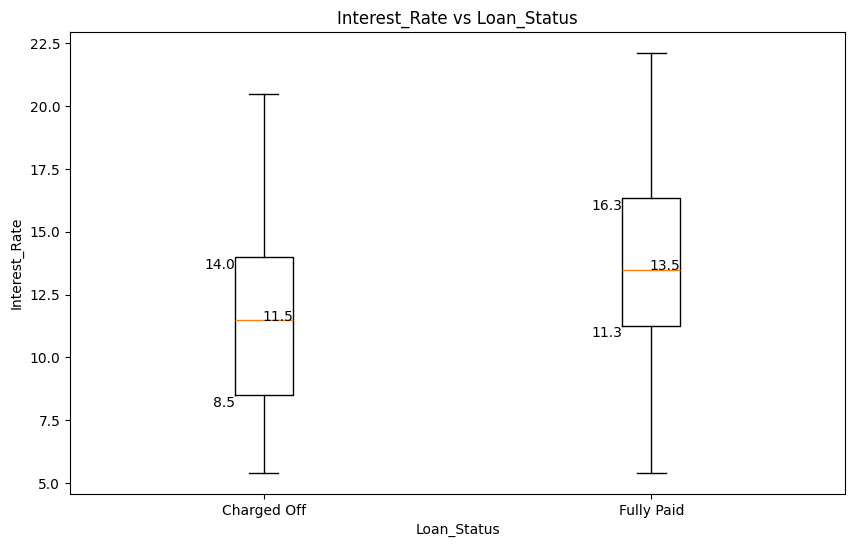

***

               count        mean         std    min       25%     50%  \
Loan_Status                                                             
Charged Off   5627.0  336.175006  217.051841  22.79  168.5550  293.87   
Current       1140.0  395.476061  204.492991  21.74  258.4700  368.19   
Fully Paid   32950.0  320.125232  207.081110  15.69  165.2825  275.65   

                 75%      max  
Loan_Status                    
Charged Off  457.840  1305.19  
Current      519.725   981.45  
Fully Paid   420.735  1295.21  


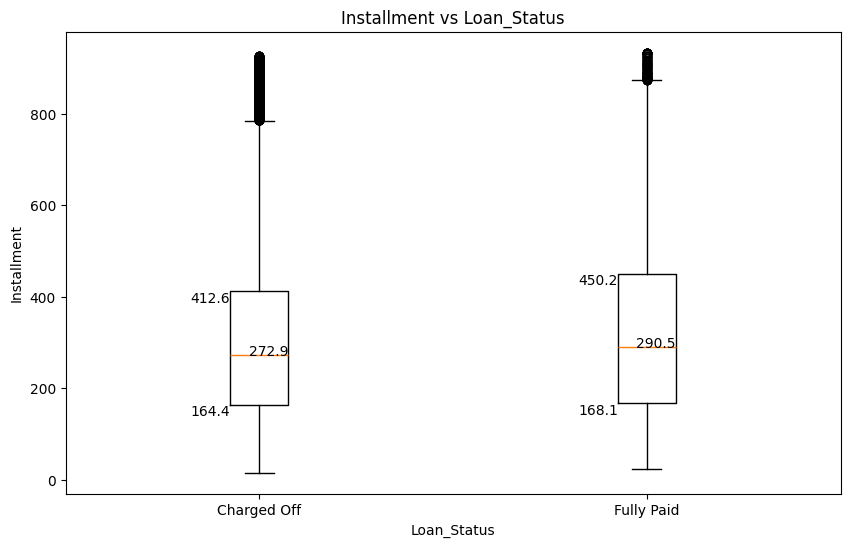

***

               count          mean           std     min       25%      50%  \
Loan_Status                                                                   
Charged Off   5627.0  62427.298034  47776.014188  4080.0  37000.00  53000.0   
Current       1140.0  75430.665105  46775.431597  9960.0  47475.00  65000.0   
Fully Paid   32950.0  69862.503328  66562.246521  4000.0  41132.75  60000.0   

                 75%        max  
Loan_Status                      
Charged Off  75000.0  1250000.0  
Current      90000.0   650000.0  
Fully Paid   84000.0  6000000.0  


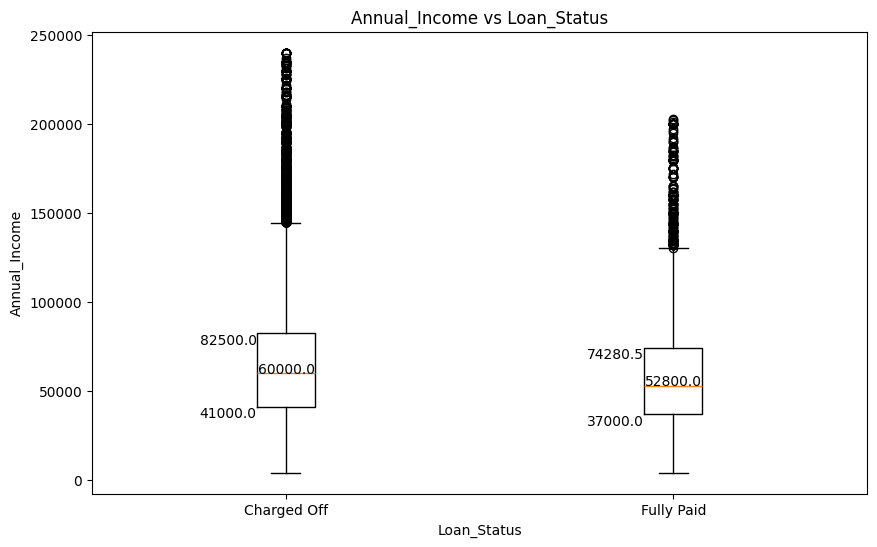

***

               count       mean       std  min    25%    50%     75%    max
Loan_Status                                                                
Charged Off   5627.0  14.000624  6.585577  0.0  9.050  14.29  19.290  29.85
Current       1140.0  14.750009  6.710482  0.0  9.745  15.05  20.045  29.95
Fully Paid   32950.0  13.148421  6.680041  0.0  7.980  13.20  18.390  29.99


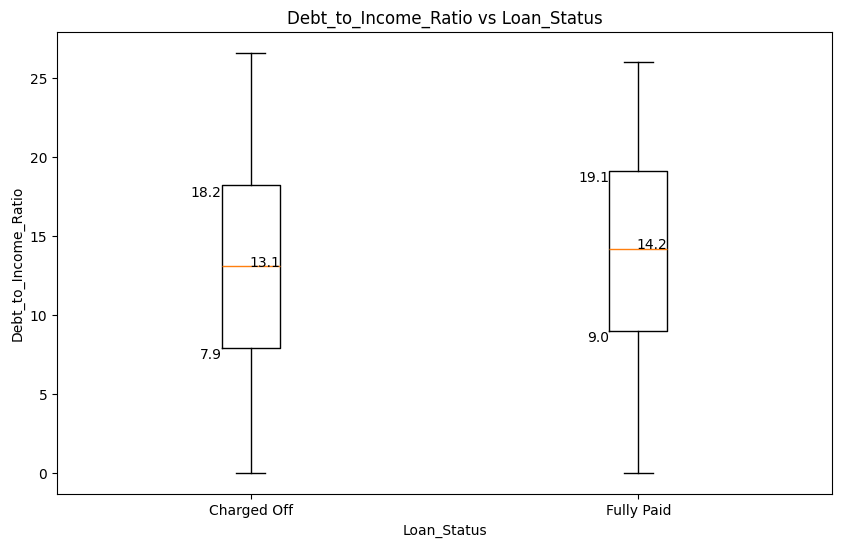

***

               count      mean       std  min  25%  50%  75%  max
Loan_Status                                                      
Charged Off   5627.0  1.058113  1.154136  0.0  0.0  1.0  2.0  8.0
Current       1140.0  0.783333  1.021061  0.0  0.0  0.0  1.0  8.0
Fully Paid   32950.0  0.839909  1.053524  0.0  0.0  1.0  1.0  8.0


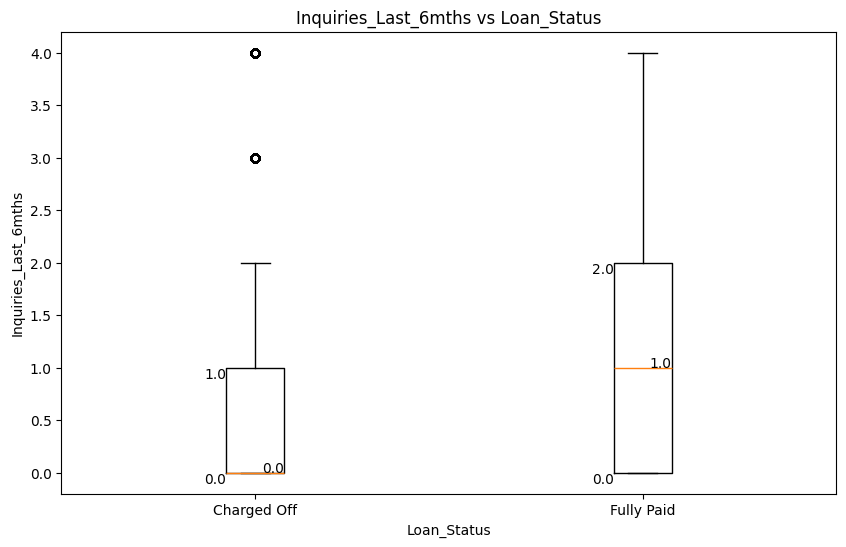

***

               count      mean       std  min  25%  50%   75%   max
Loan_Status                                                        
Charged Off   5627.0  9.178070  4.525937  2.0  6.0  8.0  12.0  38.0
Current       1140.0  9.936842  4.308704  2.0  7.0  9.0  12.0  32.0
Fully Paid   32950.0  9.292049  4.379854  2.0  6.0  9.0  12.0  44.0


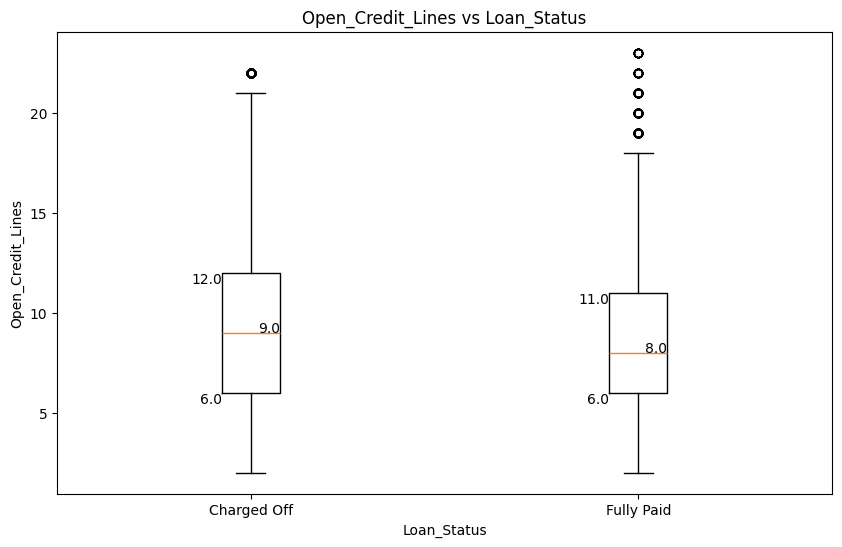

***

               count      mean       std  min  25%  50%  75%  max
Loan_Status                                                      
Charged Off   5627.0  0.084770  0.284873  0.0  0.0  0.0  0.0  2.0
Current       1140.0  0.042982  0.215497  0.0  0.0  0.0  0.0  2.0
Fully Paid   32950.0  0.050410  0.228429  0.0  0.0  0.0  0.0  4.0


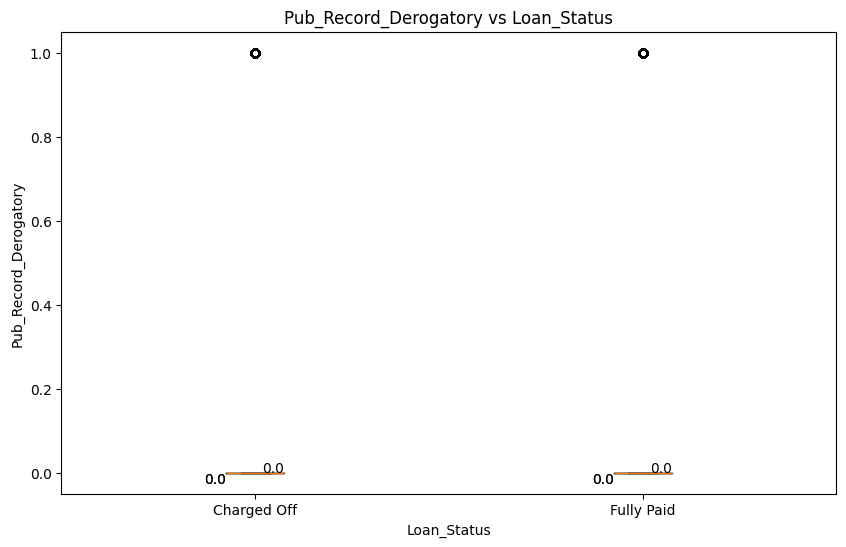

***

               count          mean           std  min      25%      50%  \
Loan_Status                                                               
Charged Off   5627.0  13514.243647  15164.117475  0.0  3968.00   9211.0   
Current       1140.0  16530.893860  16194.498722  0.0  6088.25  12627.5   
Fully Paid   32950.0  13251.107739  15983.260153  0.0  3603.00   8682.5   

                  75%       max  
Loan_Status                      
Charged Off  17518.00  148829.0  
Current      21488.25  145384.0  
Fully Paid   16804.75  149588.0  


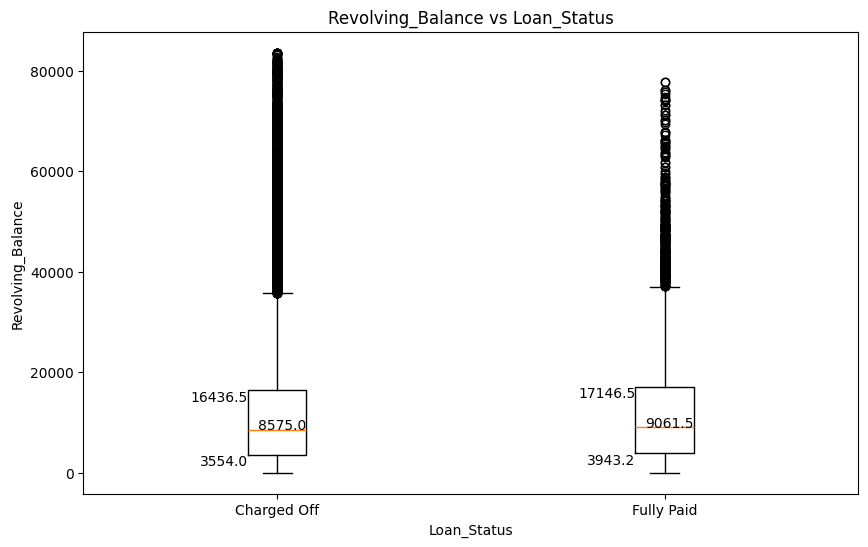

***

               count       mean        std  min     25%    50%    75%   max
Loan_Status                                                                
Charged Off   5627.0  55.554276  27.867575  0.0  34.400  58.20  78.95  99.9
Current       1140.0  53.204482  26.873188  0.0  32.575  54.95  74.80  99.9
Fully Paid   32950.0  47.533626  28.262207  0.0  23.900  47.60  70.80  99.9


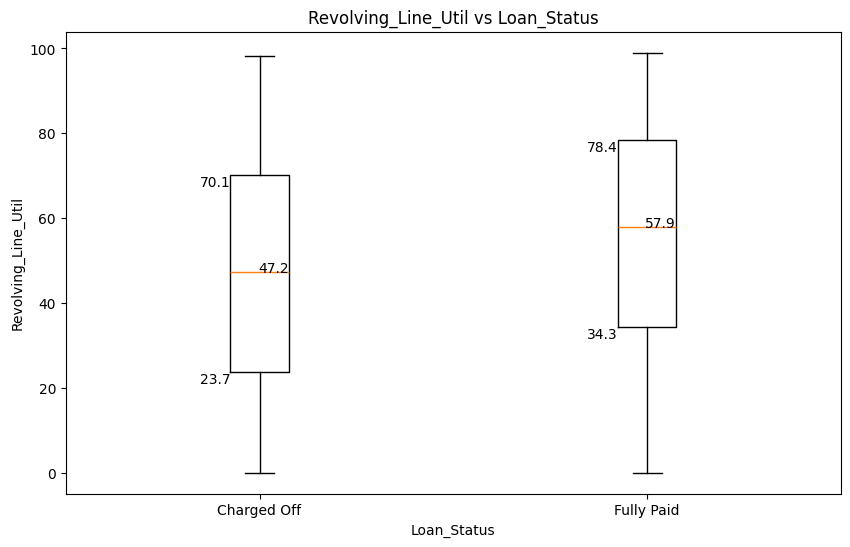

***

               count       mean        std  min   25%   50%   75%   max
Loan_Status                                                            
Charged Off   5627.0  21.427581  11.447427  2.0  13.0  20.0  28.0  74.0
Current       1140.0  23.313158  10.483115  3.0  16.0  22.0  30.0  63.0
Fully Paid   32950.0  22.159393  11.418927  2.0  14.0  20.0  29.0  90.0


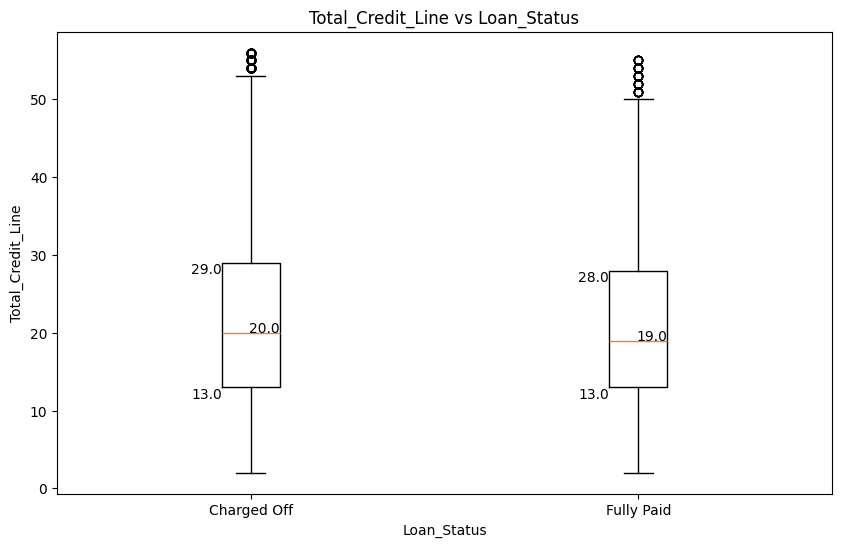

***

               count         mean          std    min      25%       50%  \
Loan_Status                                                                
Charged Off   5627.0     0.000000     0.000000   0.00    0.000     0.000   
Current       1140.0  1784.752632  1345.871778  10.26  692.575  1521.025   
Fully Paid   32950.0     0.000000     0.000000   0.00    0.000     0.000   

                   75%      max  
Loan_Status                      
Charged Off     0.0000     0.00  
Current      2542.9675  6311.47  
Fully Paid      0.0000     0.00  


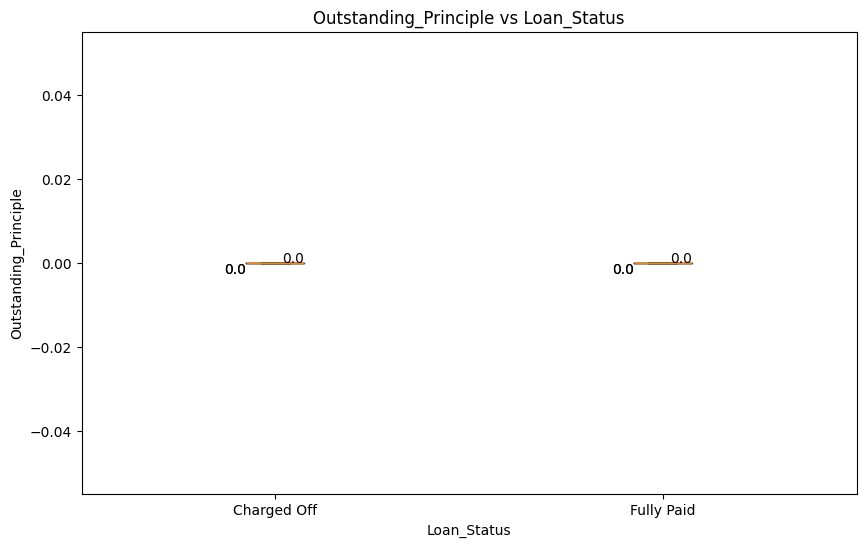

***

               count          mean           std          min           25%  \
Loan_Status                                                                   
Charged Off   5627.0   6838.030941   6615.858854     0.000000   2215.575000   
Current       1140.0  21852.875561  11192.456060  1236.180000  14348.472500   
Fully Paid   32950.0  12725.781963   8850.882238   526.332241   6139.831266   

                     50%           75%          max  
Loan_Status                                          
Charged Off   4839.00000   9191.705000  51745.45000  
Current      20370.95500  28795.752500  54427.23000  
Fully Paid   10687.15722  17025.785478  58563.67993  


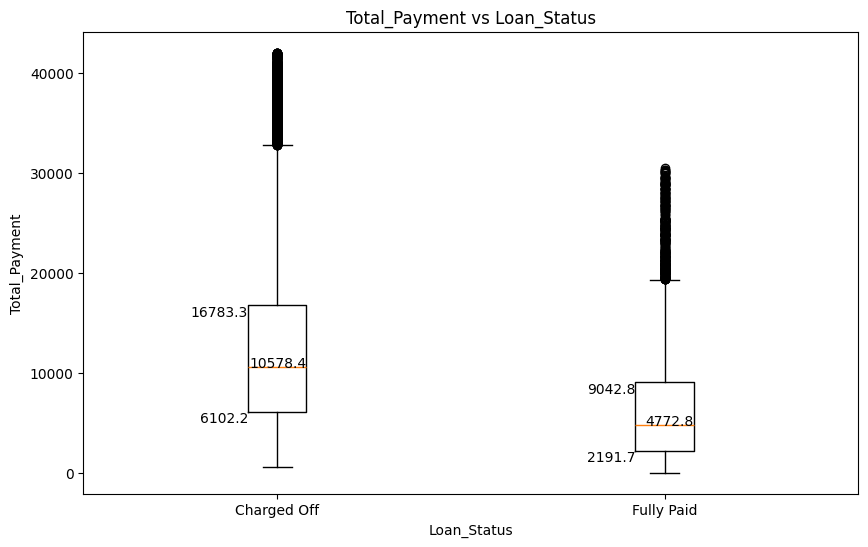

***

               count          mean           std      min        25%  \
Loan_Status                                                            
Charged Off   5627.0   6367.470474   6490.913020     0.00   1865.910   
Current       1140.0  21582.041684  11008.820927  1236.18  14030.205   
Fully Paid   32950.0  12108.624511   8753.945804     0.00   5729.990   

                  50%         75%       max  
Loan_Status                                  
Charged Off   4345.74   8544.8500  51671.58  
Current      20052.04  28535.3925  53494.05  
Fully Paid    9993.37  16285.1600  58563.68  


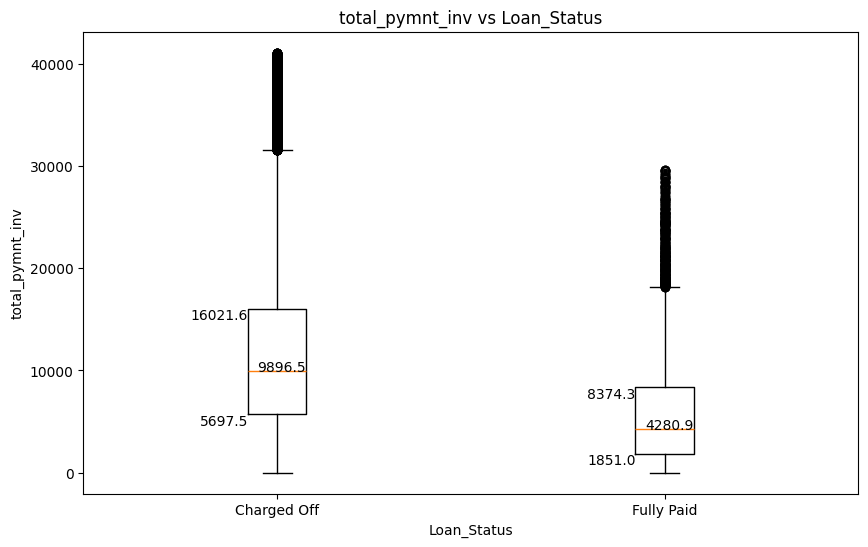

***

               count          mean          std     min        25%        50%  \
Loan_Status                                                                     
Charged Off   5627.0   3967.177947  3963.430777    0.00   1205.780   2729.590   
Current       1140.0  14700.949465  7204.816641  911.61  10140.985  13652.825   
Fully Paid   32950.0  10618.514176  6956.042362  500.00   5050.000   9200.000   

                  75%       max  
Loan_Status                      
Charged Off   5341.13  31115.81  
Current      19386.25  34911.47  
Fully Paid   14500.00  35000.02  


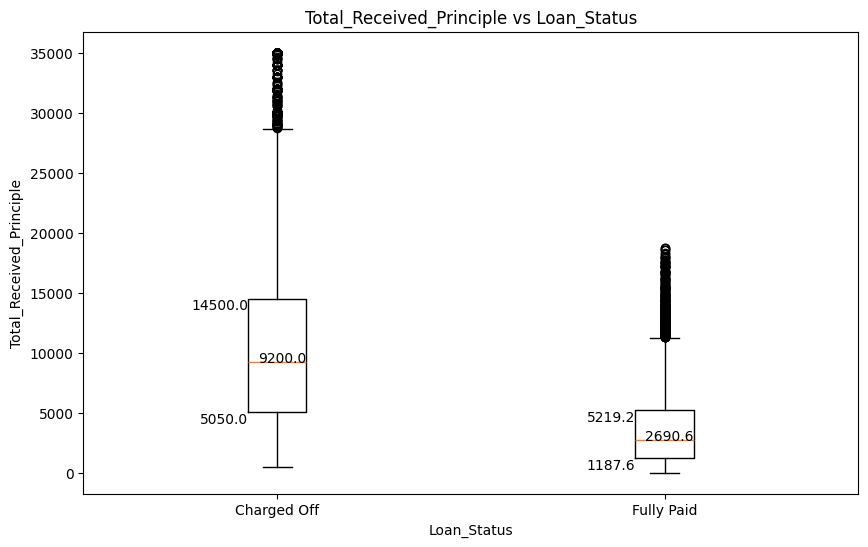

***

               count         mean          std     min        25%       50%  \
Loan_Status                                                                   
Charged Off   5627.0  2194.459385  2551.973930    0.00   555.0100  1288.260   
Current       1140.0  7150.753254  4381.742988  302.01  3851.3825  6564.595   
Fully Paid   32950.0  2106.398438  2360.436863    6.22   659.5375  1301.535   

                  75%       max  
Loan_Status                      
Charged Off  2801.615  22122.30  
Current      9468.620  23506.56  
Fully Paid   2649.360  23563.68  


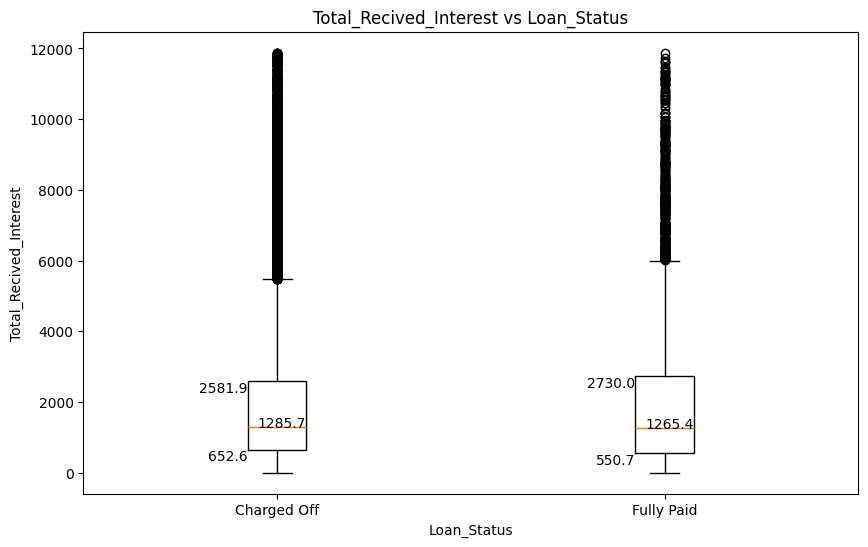

***

               count      mean       std  min  25%  50%  75%  max
Loan_Status                                                      
Charged Off   5627.0  0.065754  0.249304  0.0  0.0  0.0  0.0  2.0
Current       1140.0  0.035965  0.195483  0.0  0.0  0.0  0.0  2.0
Fully Paid   32950.0  0.038756  0.193486  0.0  0.0  0.0  0.0  2.0


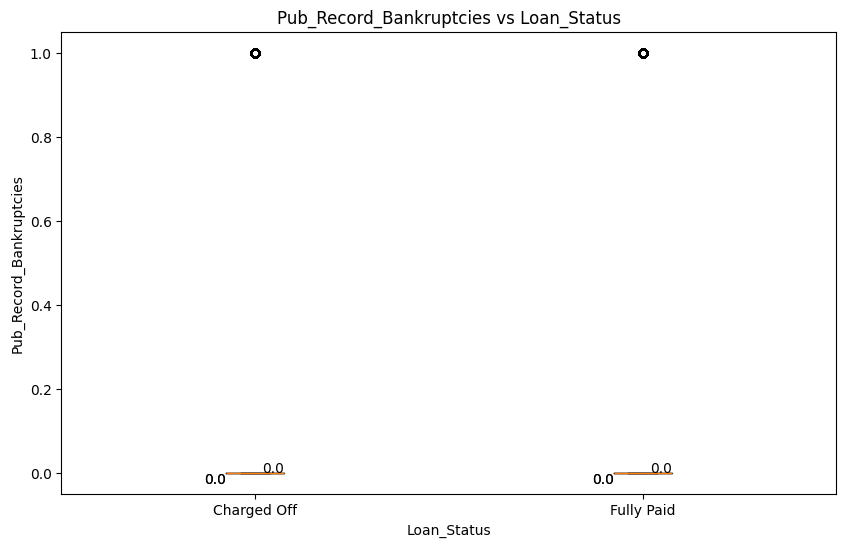

***

               count       mean        std   min   25%   50%   75%   max
Loan_Status                                                             
Charged Off   5627.0  46.236360  11.870746  36.0  36.0  36.0  60.0  60.0
Current       1140.0  60.000000   0.000000  60.0  60.0  60.0  60.0  60.0
Fully Paid   32950.0  41.157633   9.858243  36.0  36.0  36.0  36.0  60.0


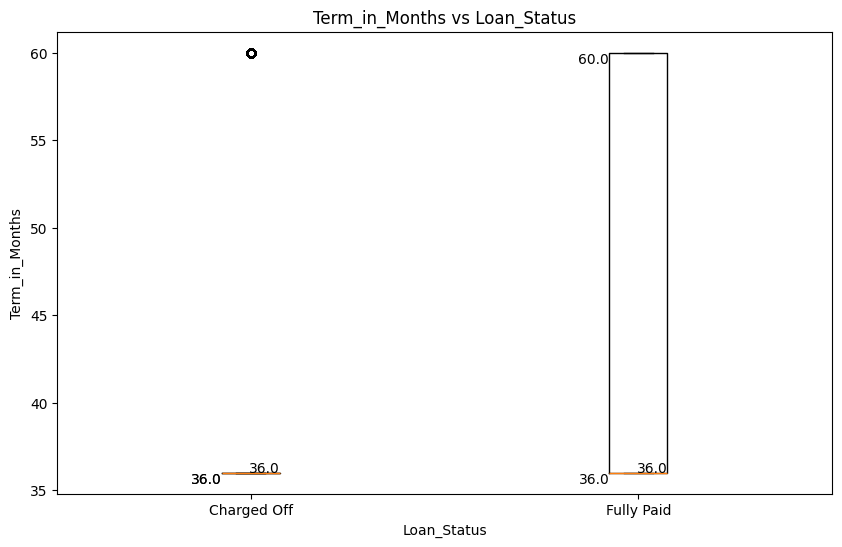

***

               count   mean  std    min    25%    50%    75%    max
Loan_Status                                                        
Charged Off   5627.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0
Current       1140.0    0.0  0.0    0.0    0.0    0.0    0.0    0.0
Fully Paid   32950.0    0.0  0.0    0.0    0.0    0.0    0.0    0.0


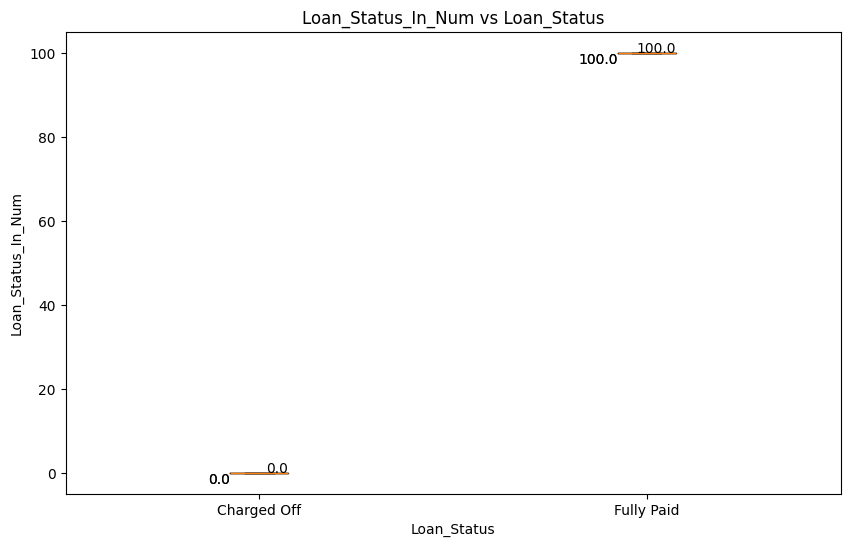

***

               count         mean          std         min          25%  \
Loan_Status                                                               
Charged Off   5627.0  5202.274836  3981.334516  340.000000  3083.333333   
Current       1140.0  6285.888759  3897.952633  830.000000  3956.250000   
Fully Paid   32950.0  5821.875277  5546.853877  333.333333  3427.729167   

                     50%     75%            max  
Loan_Status                                      
Charged Off  4416.666667  6250.0  104166.666667  
Current      5416.666667  7500.0   54166.666667  
Fully Paid   5000.000000  7000.0  500000.000000  


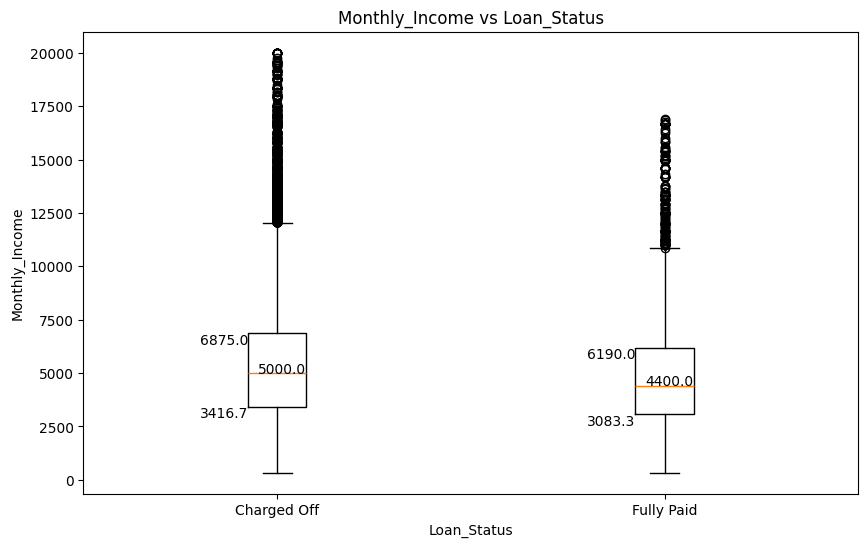

***

               count      mean       std       min       25%       50%  \
Loan_Status                                                              
Charged Off   5627.0  0.073732  0.042959  0.001664  0.039982  0.066312   
Current       1140.0  0.071832  0.037046  0.003141  0.043738  0.067026   
Fully Paid   32950.0  0.064238  0.039371  0.000289  0.034264  0.056299   

                  75%       max  
Loan_Status                      
Charged Off  0.100520  0.297558  
Current      0.095708  0.244694  
Fully Paid   0.086171  0.320262  


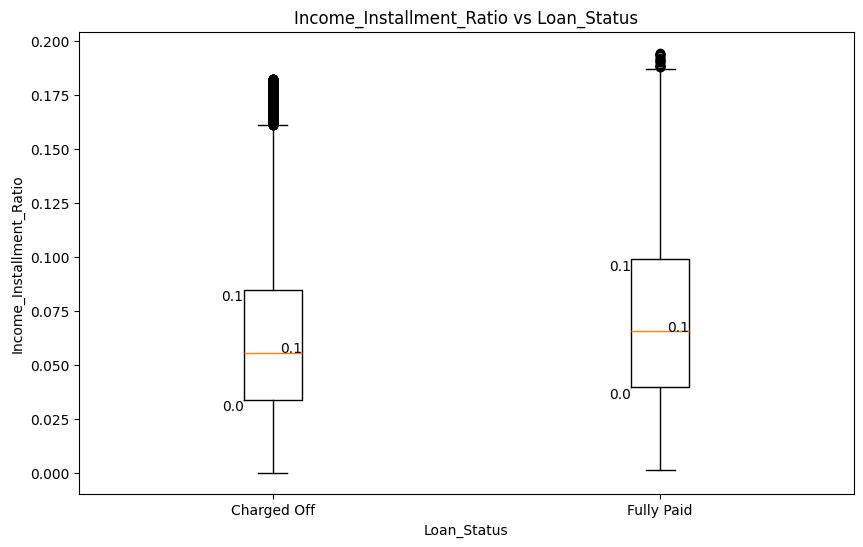

***

In [302]:
for col in num_cols:
    print(loan.groupby(by = 'Loan_Status', observed=False)[col].describe())
    labels = ['Charged Off', 'Fully Paid']
    subplot_box(loan_noncurrent, col, labels, f'{col} vs Loan_Status', 'Loan_Status', f'{col}', threshold=.99)
    md('***')
    

### Bivariate Analysis - Revolving Line Utilization
The amount of revolving credit used, divided by the total amount of revolving credit available.

               count      mean       std       min       25%       50%  \
Loan_Status                                                              
Charged Off   5627.0  0.073732  0.042959  0.001664  0.039982  0.066312   
Current       1140.0  0.071832  0.037046  0.003141  0.043738  0.067026   
Fully Paid   32950.0  0.064238  0.039371  0.000289  0.034264  0.056299   

                  75%       max  
Loan_Status                      
Charged Off  0.100520  0.297558  
Current      0.095708  0.244694  
Fully Paid   0.086171  0.320262  


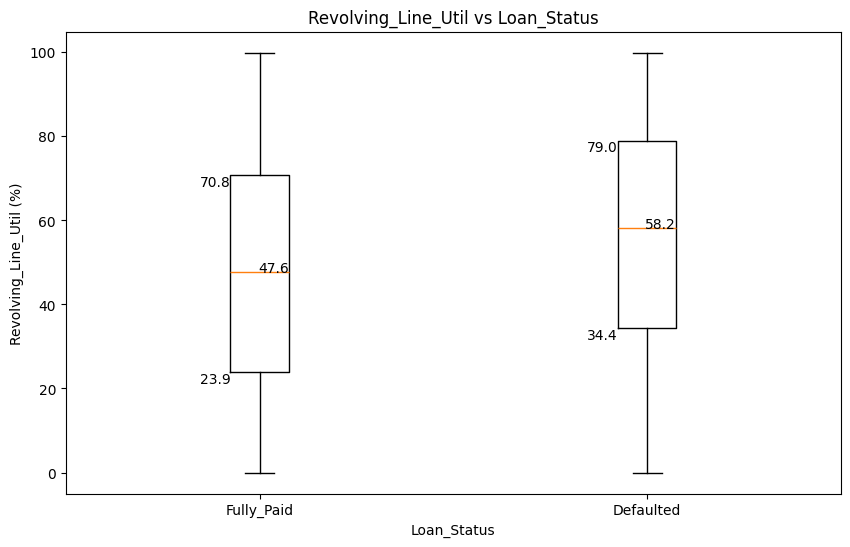

In [303]:
column = 'Revolving_Line_Util'
print(loan.groupby(by = 'Loan_Status', observed=False)[col].describe())
labels = ['Fully_Paid', 'Defaulted']
subplot_box(loan_noncurrent, column, labels, 'Revolving_Line_Util vs Loan_Status', 'Loan_Status', 'Revolving_Line_Util (%)', threshold=1)
plt.show()

##### Observation:
- Most number of defaulters carry a Revolving_Line_Util of 34% to 79%. This is against a recommended 30% [*](https://www.investopedia.com/terms/c/credit-utilization-rate.asp).
- Median of fp stays at 47.5% and for defaulters it stands at higher 58.2%.


### Bivariate Analysis - Loan Amount

               count      mean       std       min       25%       50%  \
Loan_Status                                                              
Charged Off   5627.0  0.073732  0.042959  0.001664  0.039982  0.066312   
Current       1140.0  0.071832  0.037046  0.003141  0.043738  0.067026   
Fully Paid   32950.0  0.064238  0.039371  0.000289  0.034264  0.056299   

                  75%       max  
Loan_Status                      
Charged Off  0.100520  0.297558  
Current      0.095708  0.244694  
Fully Paid   0.086171  0.320262  


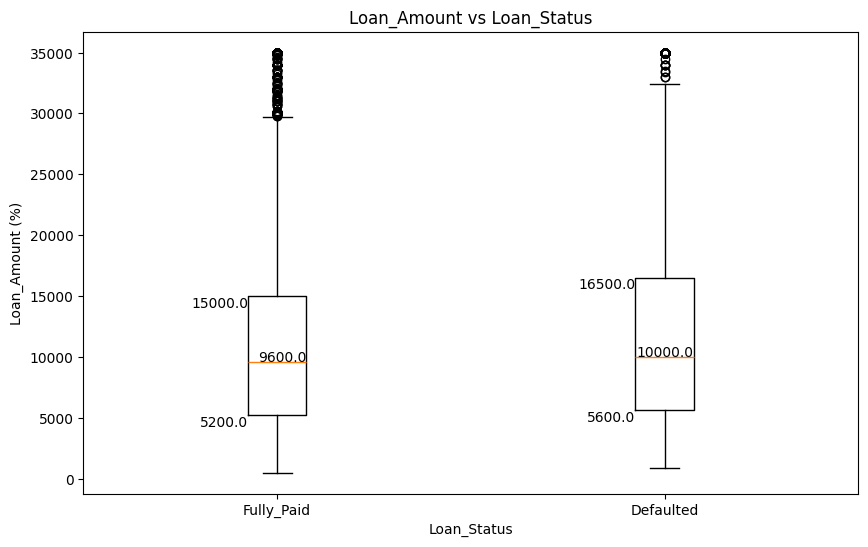

In [304]:
column = 'Loan_Amount'
print(loan.groupby(by = 'Loan_Status', observed=False)[col].describe())
labels = ['Fully_Paid', 'Defaulted']
subplot_box(loan_noncurrent, column, labels, column + ' vs Loan_Status', 'Loan_Status', column + ' (%)', threshold=1)
plt.show()

##### Observation
- The loan borrowed by the defaulters is slightly higher than the non-defaulters. This is not alarmingly high though.

### Bivariate Analysis - Interest Rate

               count      mean       std       min       25%       50%  \
Loan_Status                                                              
Charged Off   5627.0  0.073732  0.042959  0.001664  0.039982  0.066312   
Current       1140.0  0.071832  0.037046  0.003141  0.043738  0.067026   
Fully Paid   32950.0  0.064238  0.039371  0.000289  0.034264  0.056299   

                  75%       max  
Loan_Status                      
Charged Off  0.100520  0.297558  
Current      0.095708  0.244694  
Fully Paid   0.086171  0.320262  


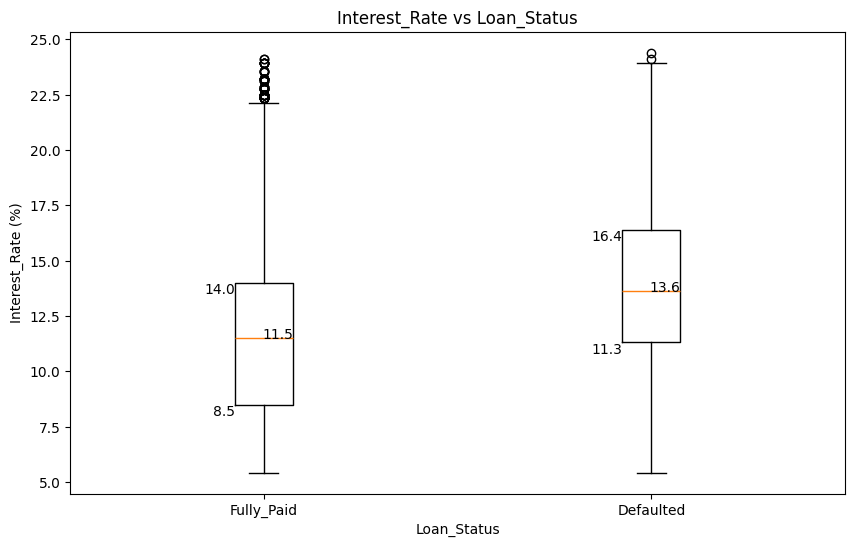

In [305]:
column = 'Interest_Rate'
print(loan.groupby(by = 'Loan_Status', observed=False)[col].describe())
labels = ['Fully_Paid', 'Defaulted']
subplot_box(loan_noncurrent, column, labels, column + ' vs Loan_Status', 'Loan_Status', column + ' (%)', threshold=1)
plt.show()

##### Observation
- The interest rates of for the defaulters are fairly high.
- The reason for this high interest rate is to cover for the losses incase they default.
- These potential defaulters may be identified by the ranking that LS has assigned to each customer.
- On the other hand, this high interest rate is a deterant for the customers to not keep up with the repayment schedule.            

### Bivariate Analysis - Annual Income

               count      mean       std       min       25%       50%  \
Loan_Status                                                              
Charged Off   5627.0  0.073732  0.042959  0.001664  0.039982  0.066312   
Current       1140.0  0.071832  0.037046  0.003141  0.043738  0.067026   
Fully Paid   32950.0  0.064238  0.039371  0.000289  0.034264  0.056299   

                  75%       max  
Loan_Status                      
Charged Off  0.100520  0.297558  
Current      0.095708  0.244694  
Fully Paid   0.086171  0.320262  


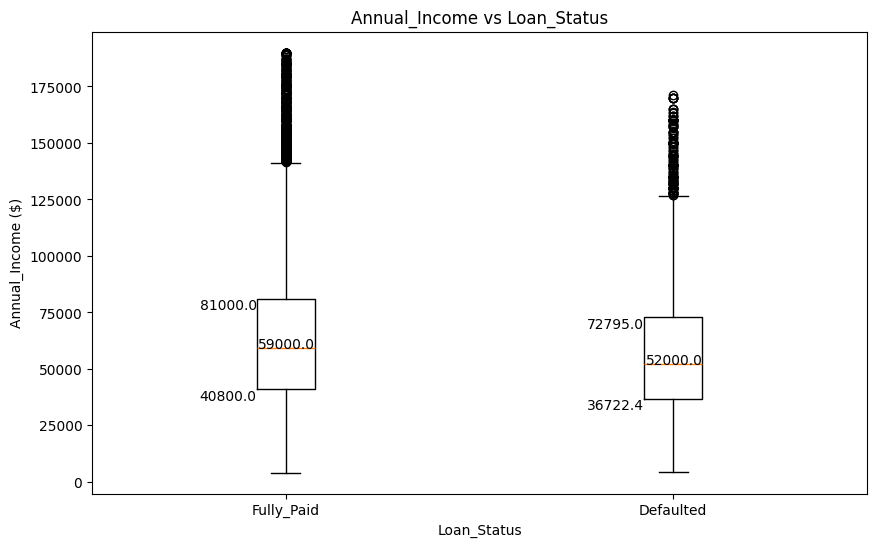

In [306]:
column = 'Annual_Income'
print(loan.groupby(by = 'Loan_Status', observed=False)[col].describe())
labels = ['Fully_Paid', 'Defaulted']
subplot_box(loan_noncurrent, column, labels, column + ' vs Loan_Status', 'Loan_Status', column + ' ($)', threshold=.98)
plt.show()

##### Observation
- The Annual_Income of the fully paid are slightly higher than the defaulters
- This paired with higher interest rates is a deterring factor for the non-repayment.

### Bivariate Analysis - Inquiries_Last_6mths

               count      mean       std       min       25%       50%  \
Loan_Status                                                              
Charged Off   5627.0  0.073732  0.042959  0.001664  0.039982  0.066312   
Current       1140.0  0.071832  0.037046  0.003141  0.043738  0.067026   
Fully Paid   32950.0  0.064238  0.039371  0.000289  0.034264  0.056299   

                  75%       max  
Loan_Status                      
Charged Off  0.100520  0.297558  
Current      0.095708  0.244694  
Fully Paid   0.086171  0.320262  


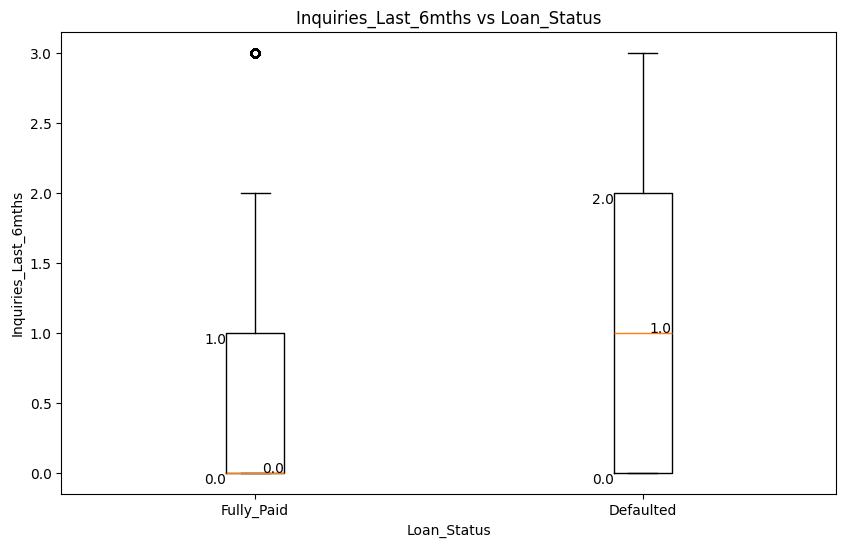

In [307]:
column = 'Inquiries_Last_6mths'
print(loan.groupby(by = 'Loan_Status', observed=False)[col].describe())
labels = ['Fully_Paid', 'Defaulted']
subplot_box(loan_noncurrent, column, labels, column + ' vs Loan_Status', 'Loan_Status', column + '', threshold=.98)
plt.show()

##### Observation
- The defaulters have made more number of inquiries with various credit institions and were not entertained.
- This is an indication that those banks see a red flag in these customers.

### Bivariate Analysis - Debt_to_Income_Ratio
This is declared by the customer. Debt-to-income ratio (DTI) is all the monthly debt payments divided by the gross monthly income.

               count      mean       std       min       25%       50%  \
Loan_Status                                                              
Charged Off   5627.0  0.073732  0.042959  0.001664  0.039982  0.066312   
Current       1140.0  0.071832  0.037046  0.003141  0.043738  0.067026   
Fully Paid   32950.0  0.064238  0.039371  0.000289  0.034264  0.056299   

                  75%       max  
Loan_Status                      
Charged Off  0.100520  0.297558  
Current      0.095708  0.244694  
Fully Paid   0.086171  0.320262  


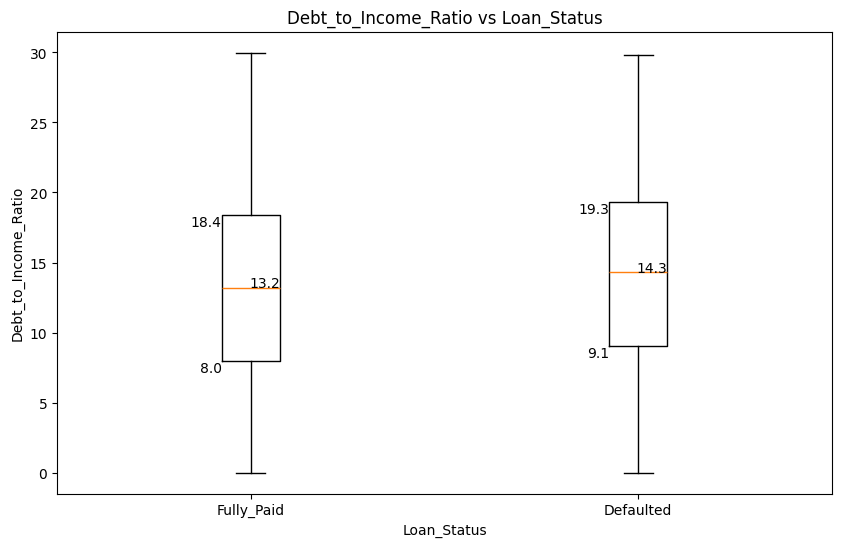

In [308]:
column = 'Debt_to_Income_Ratio'
print(loan.groupby(by = 'Loan_Status', observed=False)[col].describe())
labels = ['Fully_Paid', 'Defaulted']
subplot_box(loan_noncurrent, column, labels, column + ' vs Loan_Status', 'Loan_Status', column + '', threshold=1)
plt.show()

##### Obsertation:
- It is good to have a lower Debt_to_Income_Ratio.
- The defaulters certainly have a higher value. This is a good indicator for the risk.

***

## Segmented Analysis

### Segmented Analysis - Public Record
Count of % of defaulters among all the customers

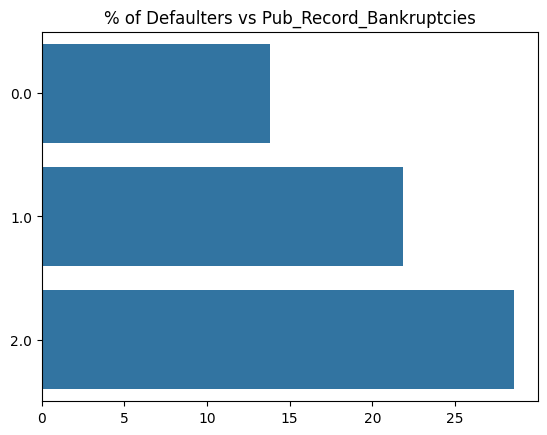

In [309]:
plot_defaulter_ratio(loan, 'Pub_Record_Bankruptcies')
plt.show()

### Segmented Analysis - Home Ownership

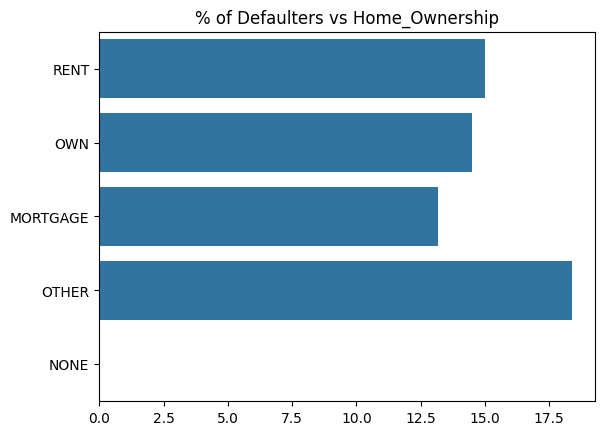

| Home_Ownership | count |
| :- | --- |
| RENT | 18899 |
| MORTGAGE | 17659 |
| OWN | 3058 |
| OTHER | 98 |
| NONE | 3 |

In [310]:
plot_defaulter_ratio(loan, 'Home_Ownership')
md_vc(loan.Home_Ownership)

##### Observation:
- Most of the defaulters have a Home_Ownership of Other. This may refer to homeless customers or living in some form of public accomodations. This generally involve low income categories.

***

## Inference